In [161]:
import numpy as np
import cupy as cp
import cupyx as cpx
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
import gc
gen = cp.random.default_rng()
import time
%matplotlib inline
# plt.rcParams['text.usetex'] = True
import os
# os.environ["CUPY_ACCELERATORS"] = "cutensor,cub,python"
# os.environ['CUPY_CUDA_PER_THREAD_DEFAULT_STREAM'] = "0"

In [162]:
# def gillespie(n_ratio, N, M = 1):
#     runs = []
#     for _ in range(M):
#         Ns = [int(n_ratio * N / (n_ratio + 1))]
#         Ns.append(N-Ns[0])
#         g = [1, -1]
#         cumulative = [0]
#         counts = np.array([0, 0]) 
#         r2 = gen.uniform(size = N)
#         for j in range(N):
#             a = [(Ns[i] - counts[i]) / (N - j) for i in range(2)]
#             mu = 0
#             n = r2[j] - a[mu]
#             mu = int(n > 0)

#             cumulative.append(cumulative[-1] + g[mu])
#             counts[mu] += 1
#     runs.append(np.array(cumulative))
#     return runs
# x = gillespie(1,100, 30)
# print(x)

In [163]:
def gillespie(N_m, N_p, M = 1):
    Ns = [[N_m, N_p]]
    N = N_m + N_p
    Ns = cp.array(Ns).T
    g = cp.array([-1, 1])
    cumulative = cp.zeros([N+1,M])
    counts = cp.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = cp.arange(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

# def gillespie(n_ratio, N, M = 1):
#     # gen = np.random.default_rng()
#     Ns = [[int(n_ratio * N / (n_ratio + 1))]]
#     Ns[0].append(N-Ns[0][0])
#     Ns = cp.array(Ns).T
#     g = cp.array([1, -1])
#     cumulative = cp.zeros([N+1,M])
#     counts = cp.zeros([2,M])
#     r2 = gen.uniform(size = [N+1,M])
#     rang = cp.arange(M)
#     for j in range(N):
#         a = (Ns - counts) / (N-j)
#         n = r2[j] - a[0]
#         mu = (n > 0) + 0
#         cumulative[j+1] = cumulative[j] + g[mu]
#         counts[mu, rang] += 1
#     return cumulative.T

In [164]:
def null_path(N_m, N_p):
    N = N_m + N_p
    j = np.arange(N+1)
    return j * (N_p - N_m) / N

In [165]:
def empirical_test(n_ratio, N, theta,j, M):
    runs = gillespie(n_ratio, N, M)
    successes = runs[:,j] == theta
    return cp.sum(successes) / M

In [166]:
# testing hypergeometric distribution
N = 100
n_ratio = 1
Np = int(N * n_ratio / (n_ratio + 1))
j = 98
theta = (2 * Np - N) * j / N
print(f'target theta = {theta}')


suc = (theta + j) / 2
if suc % 1 == 0:
    true = sp.special.comb(Np, suc) * sp.special.comb(N - Np, j - suc) / sp.special.comb(N, j)
    print(f'True probability that theta({j}) = {theta} is {np.round(true,4)}')
else:
    true = 0
    print("impossible")

test = empirical_test(n_ratio, N, theta,j, 500000)
print(f'Sample estimate: {np.round(test,4)}')

target theta = 0.0
True probability that theta(98) = 0.0 is 0.5051
Sample estimate: 0.0


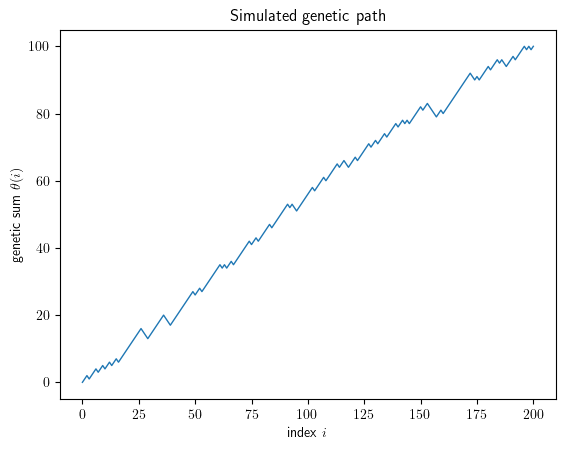

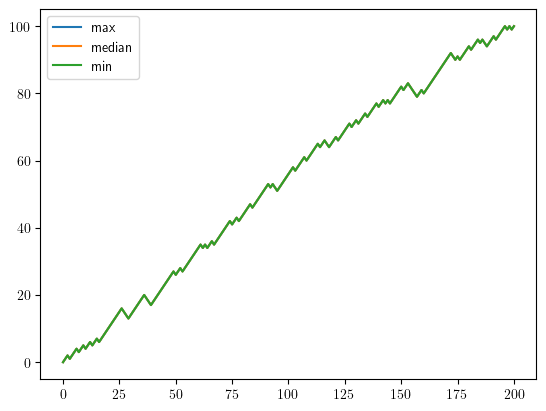

In [167]:
N_m = 50
N_p = 150
N = N_m + N_p
M = 1
j = np.arange(N+1)
x = gillespie(N_m, N_p, M).get()

fig,ax = plt.subplots()
ax.plot(j, x.T,linewidth=1,alpha=1)
# plt.ylim([-200,200])
ax.set_title("Simulated genetic path")
ax.set_xlabel(r"index $i$")
ax.set_ylabel(r"genetic sum $\theta(i)$")
plt.savefig(f'Simulated null genetic path.pdf', backend='pgf')
plt.show()

max = np.max(x,axis=0)
min = np.min(x,axis=0)
med = np.median(x,axis=0)
plt.plot(j, max,label="max")
plt.plot(j, med,label="median")
plt.plot(j, min,label="min")
plt.legend()
plt.savefig("Simulated null genetic path stats.pdf", backend='pgf')
plt.show()


In [168]:
# find empirical distribution of intersection locations (with null path) and number of intersections
def intersection_density(N_m, N_p, M): 
    N = N_p + N_m
    x0 = cp.arange(N+1) * (N_p - N_m) / N
    intersections = cp.zeros([M,N+1])
    x = gillespie(N_m, N_p, M)
    y = x - x0
    intersections = y == 0

    inter_number = cp.sum(intersections[:], axis = 1) - 1
    inters = cp.argwhere(intersections == 1).T[1] / N

    return inters.get(), inter_number.get()

# def intersection_density(n_ratio, N, M): 
#     Ns = [int(n_ratio * N / (n_ratio + 1))]
#     Ns.append(N-Ns[0])
#     x0 = cp.arange(N+1) * (Ns[0] - Ns[1]) / N
#     intersections = cp.zeros([M,N+1])
#     x = gillespie(n_ratio, N, M)
#     y = x - x0
#     # intersections[:,1:] = y[:,1:] == 0
#     intersections = y == 0

#     inter_number = cp.sum(intersections, axis = 1)
#     inters = cp.argwhere(intersections == 1).T[1] / N

#     return inters.get(), inter_number.get()

In [169]:
# slow for large K
def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,k,l] = p(z_j = k, theta(aj) = l)
    
    probs = np.zeros([J+1, J+1, N + 1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == (N_p - N_m) / N:
                continue
            pcurr = 0
            for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                N_sub_p = N_p - (l + ja - a) / 2
                if N_sub_p %1 != 0:
                    continue
                if N_sub_p > N_sub or N_sub_p < 0:
                    continue
                step = f(N_sub, N_sub_p, a, s-l)
                pcurr += probs[j-1,0,l] * step
                if pcurr != pcurr:
                    print(N_sub_p, N_sub)
                    print("fail, jsl:", j, s, l)
                    print("p,step:", probs[j-1,0,l], step)
                # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
            probs[j,0,s] = pcurr

            # print(j,0,s)
            # print(pcurr, "pcurr", probs[j,0,s])
    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)

    # for k in range(1,K+1):
    #     for j in range(k,J+1):
    
    for j in range(1,J+1):
        for k in range(1, j+1):
            ja = j* a
            N_sub = N - a * (j-1)
            for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
                pcurr = 0
                for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                    N_sub_p = N_p - (l + ja - a) / 2
                    if N_sub_p %1 != 0:
                        continue
                    if N_sub_p > N_sub or N_sub_p < 0:
                        continue
                    step = f(N_sub, N_sub_p, a, s-l)

                    if s / ja == null:
                        pcurr += probs[j-1,k-1,l] * step
                    else:
                        pcurr += probs[j-1,k,l] * step

                    if pcurr != pcurr:
                        print(N_sub_p, N_sub)
                        print("fail, jsl:", j, s, l)
                        print("p,step:", probs[j-1,k,l], step)
                        print("pcurr:", pcurr)
                    # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
                probs[j,k,s] = pcurr
    
    secondloop = time.time()
    print("Time to complete first loop: ", secondloop - firstloop)
    ptot = np.sum(probs, axis = 2)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot[-1]

# N_m = 25
# N_p = 25

# d = np.gcd(N_m, N_p)
# a = (N_m + N_p) / d

# M = 1000000
# _, intnums = intersection_density(N_m, N_p, M)
# y = np.unique_counts(intnums)[1]/M
# print(y)

# x = intersect_num_dp(N_m, N_p)
# print(x[1:len(y)+1])

In [170]:
# faster (vectorised instead of k loop)

def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,l,k] = p(z_j = k, theta(aj) = l)
    
    probs = np.zeros([J+1, N + 1, J+1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == (N_p - N_m) / N:
                continue
            pcurr = 0
            for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                N_sub_p = N_p - (l + ja - a) / 2
                if N_sub_p %1 != 0:
                    continue
                if N_sub_p > N_sub or N_sub_p < 0:
                    continue
                step = f(N_sub, N_sub_p, a, s-l)
                pcurr += probs[j-1,l, 0] * step
                if pcurr != pcurr:
                    print(N_sub_p, N_sub)
                    print("fail, jsl:", j, s, l)
                    print("p,step:", probs[j-1,l, 0], step)
                # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
            probs[j,s,0] = pcurr

            # print(j,0,s)
            # print(pcurr, "pcurr", probs[j,0,s])
    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)

    # for k in range(1,K+1):
    #     for j in range(k,J+1):
    
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                N_sub_p = 2 * N_p - (l + ja - a) 
                if N_sub_p %2 != 0:
                    continue
                N_sub_p = int(N_sub_p / 2)
                if N_sub_p > N_sub or N_sub_p < 0:
                    continue
                step = f(N_sub, N_sub_p, a, s-l)

                k = np.arange(1,j+1)
                if s / ja == null:
                    probs[j,s,k] += probs[j-1,l,k-1] * step
                else:
                    probs[j,s,k] += probs[j-1,l,k] * step

    secondloop = time.time()
    print("Time to complete second loop: ", secondloop - firstloop)
    ptot = np.sum(probs[-1], axis = 0)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot


# N_m = 60
# N_p = 50

# d = np.gcd(N_m, N_p)
# a = (N_m + N_p) / d

# M = 200000
# _, intnums = intersection_density(N_m, N_p, M)
# y = np.unique_counts(intnums)[1]/M

# x = intersect_num_dp(N_m, N_p)
# print(x[1:len(y)+1])

# print((y - x[1:len(y)+1])/y)

In [171]:
# fastest (vectorised in l loop)
def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,l,k] = p(z_j = k, theta(aj) = l)
    probs = np.zeros([J+1, N + 1, J+1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == null:
                continue
            l = np.arange(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1)
            N_sub_p = N_p - (l + ja - a) / 2
            
            valid = np.where((N_sub_p %1 == 0) * (N_sub_p <= N_sub) * (N_sub_p >= 0), 1, 0)

            step = np.multiply(f(N_sub, N_sub_p, a, s-l), valid)
            step = np.nan_to_num(step)

            probs[j,s,0] = step @ probs[j-1,l,0]

    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)
    
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            l = np.arange(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1)
            N_sub_p = N_p - (l + ja - a) / 2
            
            valid = np.where((N_sub_p %1 == 0) * (N_sub_p <= N_sub) * (N_sub_p >= 0), 1, 0)

            step = np.multiply(f(N_sub, N_sub_p, a, s-l), valid)
            step = np.nan_to_num(step)
            k = np.arange(1,j+1)

            if s / ja == null:
                probs[j,s,k] = step @ probs[j-1,l][:,k-1]
            else:
                probs[j,s,k] = step @ probs[j-1,l][:,k]

    secondloop = time.time()
    print("Time to complete second loop: ", secondloop - firstloop)
    ptot = np.sum(probs[-1], axis = 0)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot


N_m = 50
N_p = 50

d = np.gcd(N_m, N_p)
a = (N_m + N_p) / d

M = 200000
_, intnums = intersection_density(N_m, N_p, M)
y = np.unique_counts(intnums)[1]/M

x = intersect_num_dp(N_m, N_p)
print(x[1:len(y)+1])

print((y - x[1:len(y)+1])/y)

Time to complete first loop:  0.3696603775024414
Time to complete second loop:  0.3921976089477539
[1.01010101e-02 2.02020202e-02 2.99906279e-02 3.91544309e-02
 4.73974690e-02 5.44566665e-02 6.01170369e-02 6.42244120e-02
 6.66945817e-02 6.75179716e-02 6.67593427e-02 6.45524223e-02
 6.10898403e-02 5.66091901e-02 5.13764078e-02 4.56679181e-02
 3.97530973e-02 3.38785363e-02 2.82553499e-02 2.30504170e-02
 1.83819781e-02 1.43195385e-02 1.08875830e-02 8.07225835e-03
 5.82996436e-03 4.09673171e-03 2.79734684e-03 1.85338618e-03
 1.18959797e-03 7.38371153e-04 4.42309290e-04 2.55146156e-04
 1.41377627e-04 7.50378959e-05 3.80282549e-05 1.83350515e-05
 8.37527043e-06 3.60713478e-06]
[ 0.02216746  0.01236763  0.0113523  -0.00965526  0.00665474 -0.00113368
  0.00927757  0.00218423 -0.00352967 -0.00175032  0.00366625 -0.00942021
  0.00188154 -0.00069277 -0.01334138  0.01237201 -0.02403651  0.00867487
 -0.00107529  0.01703979  0.00637956 -0.04905044 -0.00810954  0.01976219
  0.01603977 -0.02035659  0.

In [172]:
# # fastest (vectorised in s loop)
# def intersect_num_dp(N_m, N_p, J=-1, K=-1):

#     def f(N, N_p, ind, theta):
#         n_p = (ind + theta) / 2
#         return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
#     N = N_m + N_p
#     d = np.gcd(N,N_p)
#     a = int(N / d)
#     if J == -1:
#         J = N
#     if K == -1:
#         K = d
#     J = int(J/a)

#     # we define probs[j,l,k] = p(z_j = k, theta(aj) = l)
    
#     probs = np.zeros([J+1, N + a + 1, J+1])
#     probs[0,0,0] = 1
#     null = (N_p - N_m) / N
    
#     starttime = time.time()
#     # for k = 0
#     for j in range(1,J+1):
#         ja = j * a
#         N_sub = N - a * (j-1)
#         for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
#             if s / ja == (N_p - N_m) / N:
#                 continue
#             pcurr = 0
#             for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
#                 N_sub_p = N_p - (l + ja - a) / 2
#                 if N_sub_p %1 != 0:
#                     continue
#                 if N_sub_p > N_sub or N_sub_p < 0:
#                     continue
#                 step = f(N_sub, N_sub_p, a, s-l)
#                 pcurr += probs[j-1,l, 0] * step
#                 if pcurr != pcurr:
#                     print(N_sub_p, N_sub)
#                     print("fail, jsl:", j, s, l)
#                     print("p,step:", probs[j-1,l, 0], step)
#                 # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
#             probs[j,s,0] = pcurr

#             # print(j,0,s)
#             # print(pcurr, "pcurr", probs[j,0,s])
#     firstloop = time.time()
#     print("Time to complete first loop: ", firstloop - starttime)

#     for j in range(1,J+1):
#         ja = j * a
#         N_sub = N - a * (j-1)

#         s = np.arange(np.max([-ja, -N_m]), np.min([ja, N_p])+1)
#         l = np.arange(-a, a+1)

#         olds = np.array([s]).T - l
#         N_sub_p = N_p - (olds + ja - a) / 2
#         valid = np.where(np.multiply((N_sub_p %1 == 0), (N_sub_p <= N_sub), (N_sub_p >= 0)), 1, 0)
#         step = np.array([np.multiply(f(N_sub, N_sub_p, a, l), valid)])
#         step = np.nan_to_num(step).transpose(1,0,2)

#         k = np.arange(1,j+1)
#         # print((step @ probs[j-1,diffs])[:,0,:], "mult")
#         probs[j,s,1:j+1] = np.matmul(step, probs[j-1,olds,1:j+1])[:,0,:]
#         probs[j, int(ja * null), 1:j+1] = np.matmul(step[int(ja * null)], probs[j-1, int(ja * null)-l,0:j])
#     print("0", probs[-2,0,0])
#     print(probs.shape)
#     # print(np.sum(probs[-2], axis=0))
#     secondloop = time.time()
#     print("Time to complete second loop: ", secondloop - firstloop)
#     ptot = np.sum(probs, axis = 1)
#     # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
#     return ptot

# # N_m = 10
# # N_p = 10

# # d = np.gcd(N_m, N_p)
# # a = (N_m + N_p) / d

# # M = 200000
# # _, intnums = intersection_density(N_m, N_p, M)
# # y = np.unique_counts(intnums)[1]/M

# # x = intersect_num_dp(N_m, N_p)[-1]
# # print("x", x)
# # print("y", y)
# # print("err", (y - x[1:len(y)+1])/y)

In [173]:
# # for nr = 2
# def intersect_num_dp(N,k,l = -1):
#     '''Assume N+ = N-'''
#     if l == -1:
#         l = N
#     if l % 2 != 0:
#         print("non-int")

#     def f(N,c,a):
#         return (1 / ((a - c)*2 - 1)) * sp.special.comb((N - c * 2)/ 2, a-c) ** 2 / sp.special.comb(N - 2 * c, 2 * (a-c))

#     dp = np.zeros([int(l/2)+1, k]) # P j_b = a n_r
#     dp[0,0] = 1
#     dp[1,1] = sp.special.comb(N / 2, 1) * sp.special.comb(N / 2, 1) / sp.special.comb(N, 2)
#     for i in range(2, int(l/2)+1):
#         for b in range(1,k):
#             if b <= i:
#                 x = [dp[c,b-1] * f(N, c, i) for c in range(i)]
#                 dp[i,b] = np.sum(x)
#     dp = np.concatenate([np.zeros([int(l/2 + 1),1]),dp],axis=1)
#     return dp[-1]

# d = intersect_num_dp(300,50)
# print(d)

In [174]:
# runs = []
# del runs
# cp._default_memory_pool.free_all_blocks()

# n_ratios = [i for i in range(1,6)]
# N1 = [i * 300 for i in range(1,4)]
# M = 20000
# runs = []
# for N in N1:
#     runs.append([])
#     for n_ratio in n_ratios:
#         runs[-1].append(intersection_density(n_ratio, N, M))

In [175]:
def null_intersection_exact(N_m, N_p):
    N = N_p + N_m
    probs = []
    for j in range(N+1):
        prob = float(sp.stats.hypergeom.pmf(k=j * N_p / N, N=j, n=N_p, M=N))
        probs.append(prob)
    return probs

In [176]:
N_m = 2**np.arange(0,10)
N_p = 2**np.arange(0,10)
N = N_m + N_p

sums = np.zeros_like(N)
for j in range(len(N)):
    probs = null_intersection_exact(N_m[j], N_p[j])
    sums[j] = sum(probs)
print("sqrt2", np.sqrt(2))
print(sums[1:] / sums[:-1])

sqrt2 1.4142135623730951
[1.         1.5        1.66666667 1.4        1.42857143 1.4
 1.42857143 1.4        1.42857143]


In [177]:
q=20
m = 4
b = 0
print(f'sqrtm={np.sqrt(m)}')
N_m = gen.integers(1,10).get()
N_p = gen.integers(1,10).get()
print(N_m,N_p)

probs = null_intersection_exact(N_m, N_p)
sumsrand = np.array([sum(probs)+b])

for j in range(q):
    N_m*=m
    N_p*=m
    probs = null_intersection_exact(N_m, N_p)
    sums = np.concatenate([sums,[np.sum(probs)+b]])
    print(f'j = {j}, ratio = {sums[-1] / sums[-2]}')

sqrtm=2.0
5 7
j = 0, ratio = 0.06892077759749202
j = 1, ratio = 1.5337748500175552
j = 2, ratio = 1.6942189453960277
j = 3, ratio = 1.8194593622202255
j = 4, ratio = 1.9008219438730052
j = 5, ratio = 1.947845132321963
j = 6, ratio = 1.9732309435978996


KeyboardInterrupt: 

In [178]:
N_m = 3**np.arange(0,12)
N_p = 3**np.arange(0,12)
N = N_m + N_p

sums = np.zeros_like(N)
for j in range(len(N)):
    probs = null_intersection_exact(N_m[j], N_p[j])
    sums[j] = sum(probs)
print(sums[1:] / sums[:-1])

print(np.sqrt(3))

KeyboardInterrupt: 

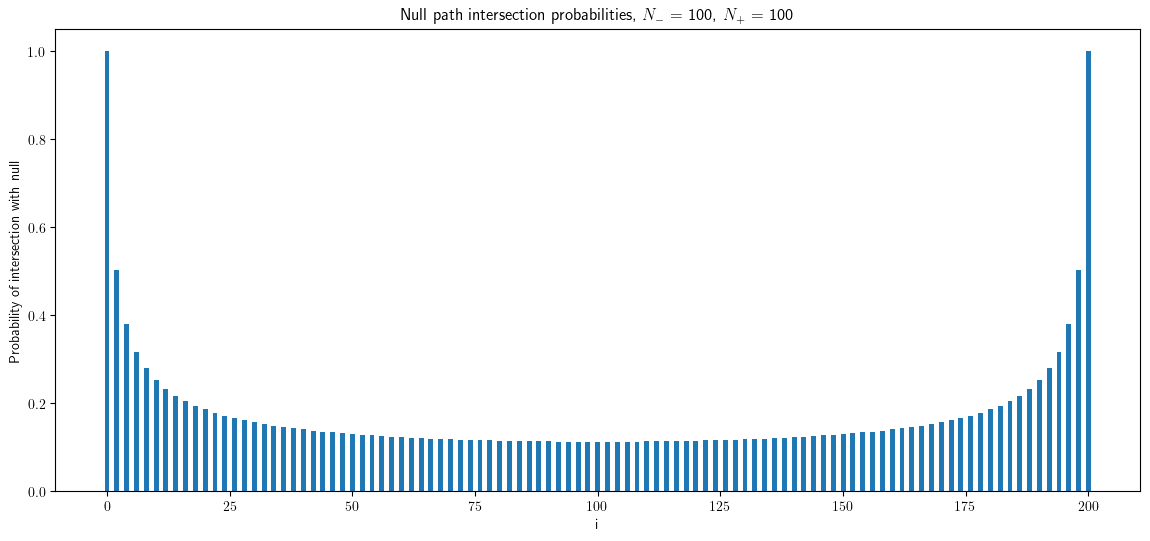

In [189]:
N_m = 100
N_p = 100
N = N_m + N_p

probs = null_intersection_exact(N_m, N_p)
x = np.arange(N+1)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)
ax.set_title(f"Null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}")
ax.set_ylabel("Probability of intersection with null")
ax.set_xlabel("i")
ax.bar(x, probs, width = 1)
plt.show()

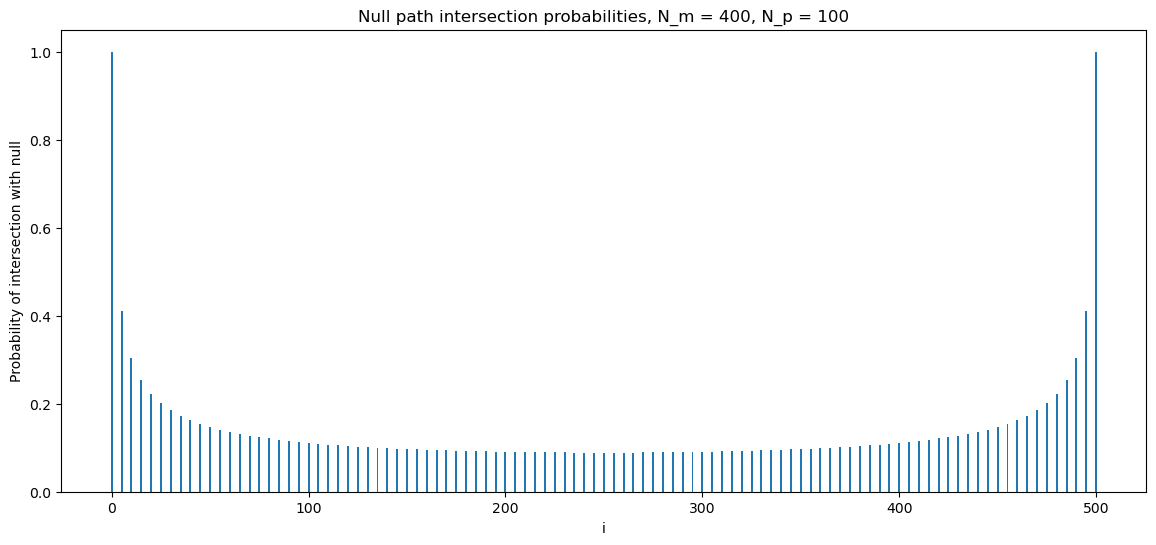

In [ ]:
N_m = 400
N_p = 100
N = N_m + N_p

probs = null_intersection_exact(N_m, N_p)

x = np.arange(N+1)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)
ax.set_title(f"Null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}")
ax.set_ylabel("Probability of intersection with null")
ax.set_xlabel("i")
ax.bar(x, probs, width = 1)
plt.show()

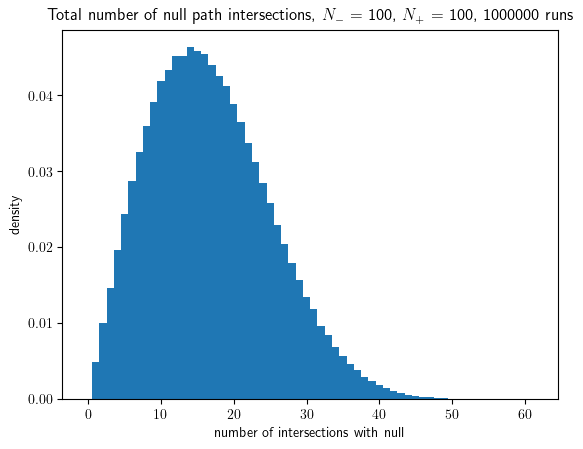

In [190]:
N_m = 100
N_p = 100
N = N_m + N_p
M = 1000000

_, inter_number = intersection_density(N_m, N_p, M)

fig, ax = plt.subplots()
ax.hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
ax.set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
plt.show()

Time to complete first loop:  2.096755266189575
Time to complete second loop:  2.2951016426086426


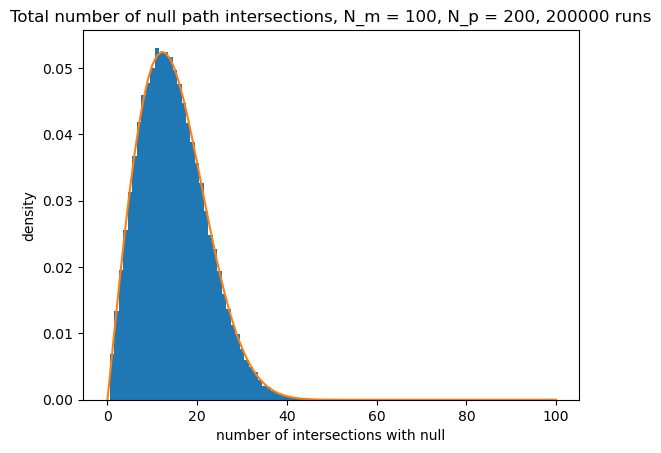

In [ ]:
N_m = 100
N_p = 200
N = N_m + N_p
M = 200000

_, inter_number = intersection_density(N_m, N_p, M)

fig, ax = plt.subplots()
ax.hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
ax.set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
pred1 = intersect_num_dp(N_m, N_p, K=30)
t = np.arange(60)
ax.plot(pred1)
plt.show()

Time to complete first loop:  2.093763828277588
Time to complete second loop:  2.2687392234802246


ValueError: x and y must have same first dimension, but have shapes (51,) and (101,)

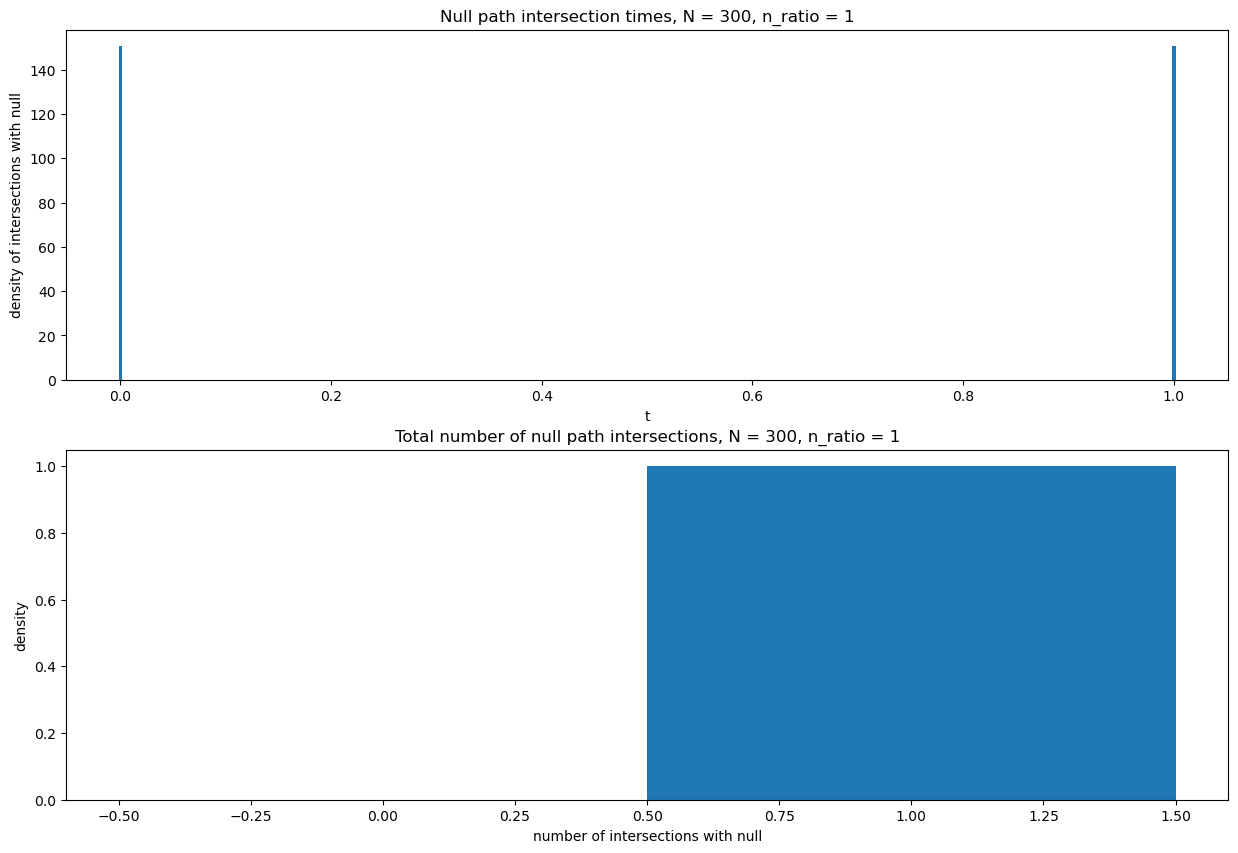

In [55]:
inters, inter_number = [],[]
del inters, inter_number
cp._default_memory_pool.free_all_blocks()

# d = intersect_num_dp(300,50)
gc.collect()

n_ratios = [i for i in range(1,6)]
N1 = [i * 300 for i in range(1,5)]
M = 20000


for i in range(len(N1)):
    for j in range(len(n_ratios)):
        
        N = N1[i]
        n_ratio = n_ratios[j]
        # inters, inter_number = runs[i][j]
        inters, inter_number = intersection_density(n_ratio, N, M)
        
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(15)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        

        axs[1].plot(np.arange(51), intersect_num_dp(N_m, N_p))
        plt.show()

        del inters, inter_number
        gc.collect()
        cp._default_memory_pool.free_all_blocks()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (301,) and arg 1 with shape (241,).

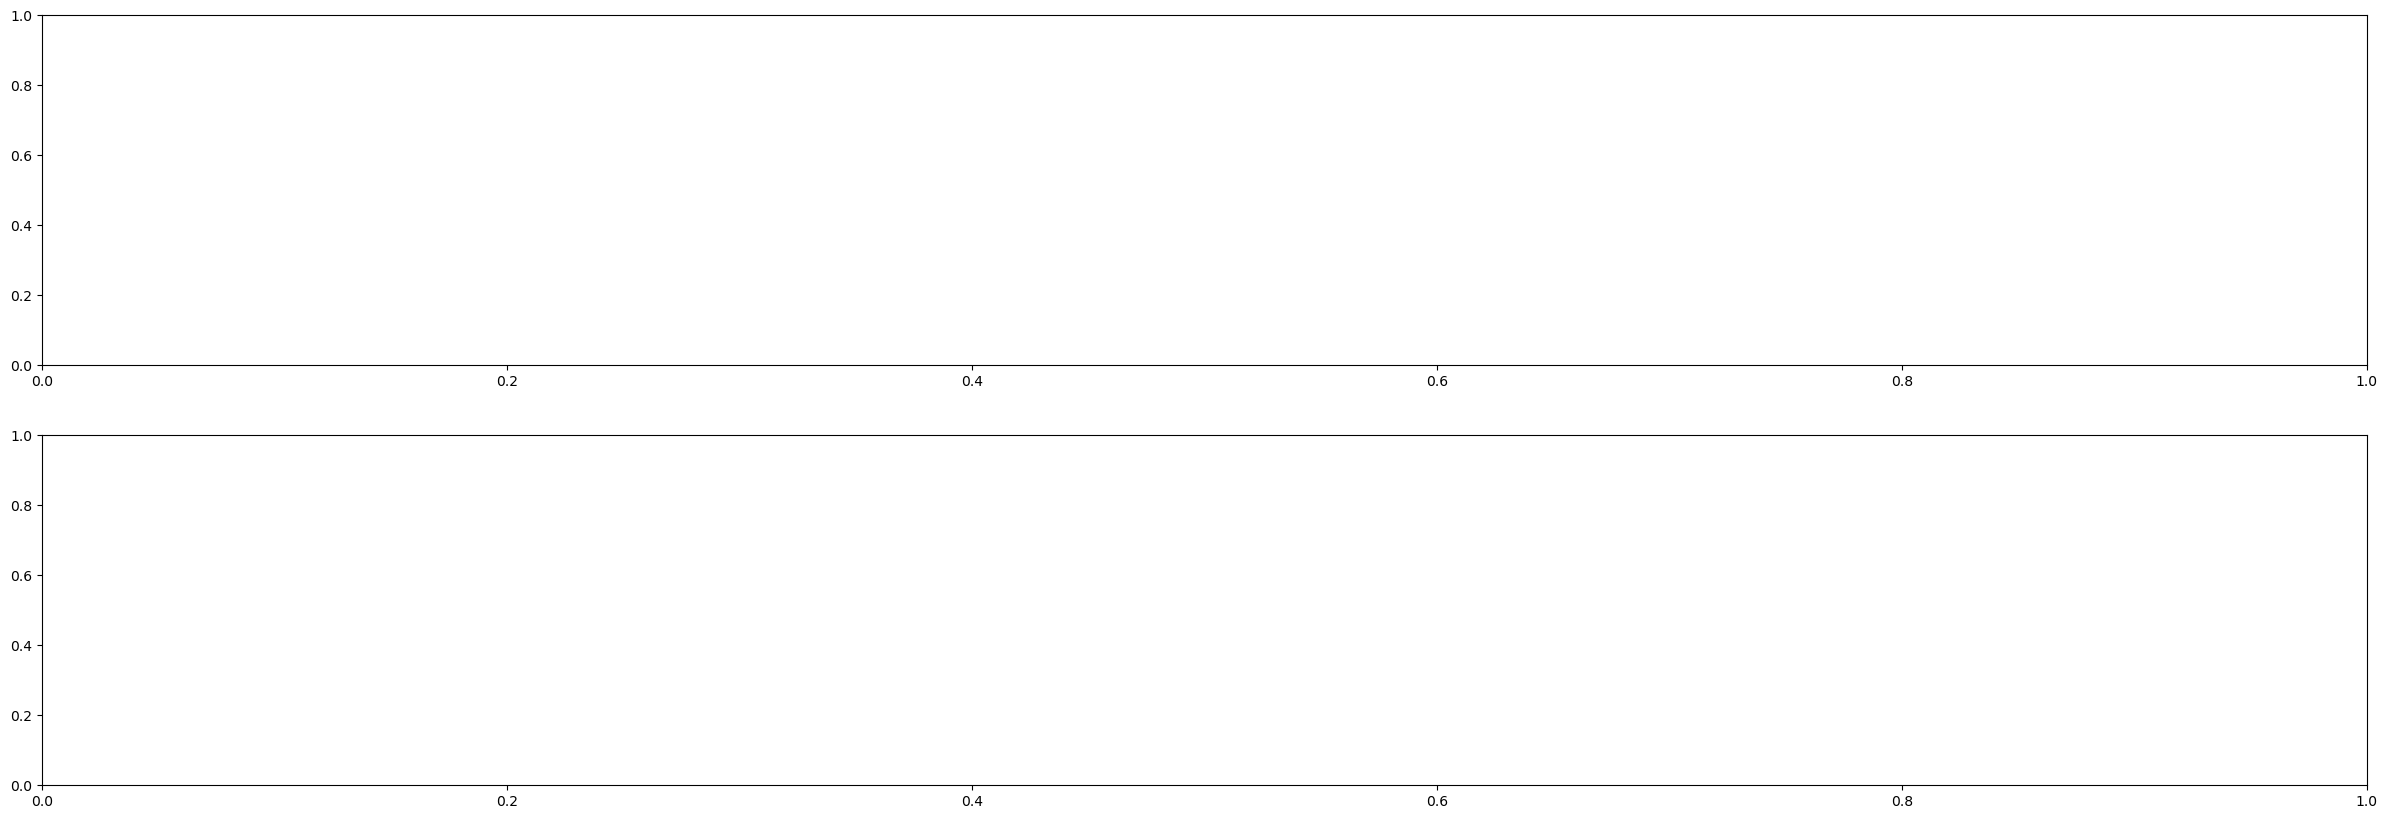

In [ ]:
k=100

for i in range(len(N1)):
    for j in range(len(n_ratios)):
        N = N1[i]
        n_ratio = n_ratios[j]

        _, inter_number = intersection_density(n_ratio, N, M)


        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        x = np.arange(N+1)
        axs[0].bar(x,prob_array[i][j])
        axs[0].set_title(f"Null path intersection probabilities, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("Probability of intersection with null")
        
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        
        Np = int(N / (n_ratio + 1))

        d = np.gcd(N, Np)
        # print(d)
        # print(N/n_ratio)
        # print(N / (N/d - 1))
        
        if int(N / (N/d - 1)) >= 2:
            axs[1].plot(np.arange(k+1), intersect_num_dp(int(N / (N/d - 1) / 2 + n_ratio)*2, k))
        plt.show()

        del inter_number
        gc.collect()
        cp._default_memory_pool.free_all_blocks()

[5 6 1 ... 2 6 7]
Time to complete first loop:  0.2557651996612549
Time to complete second loop:  0.24758243560791016


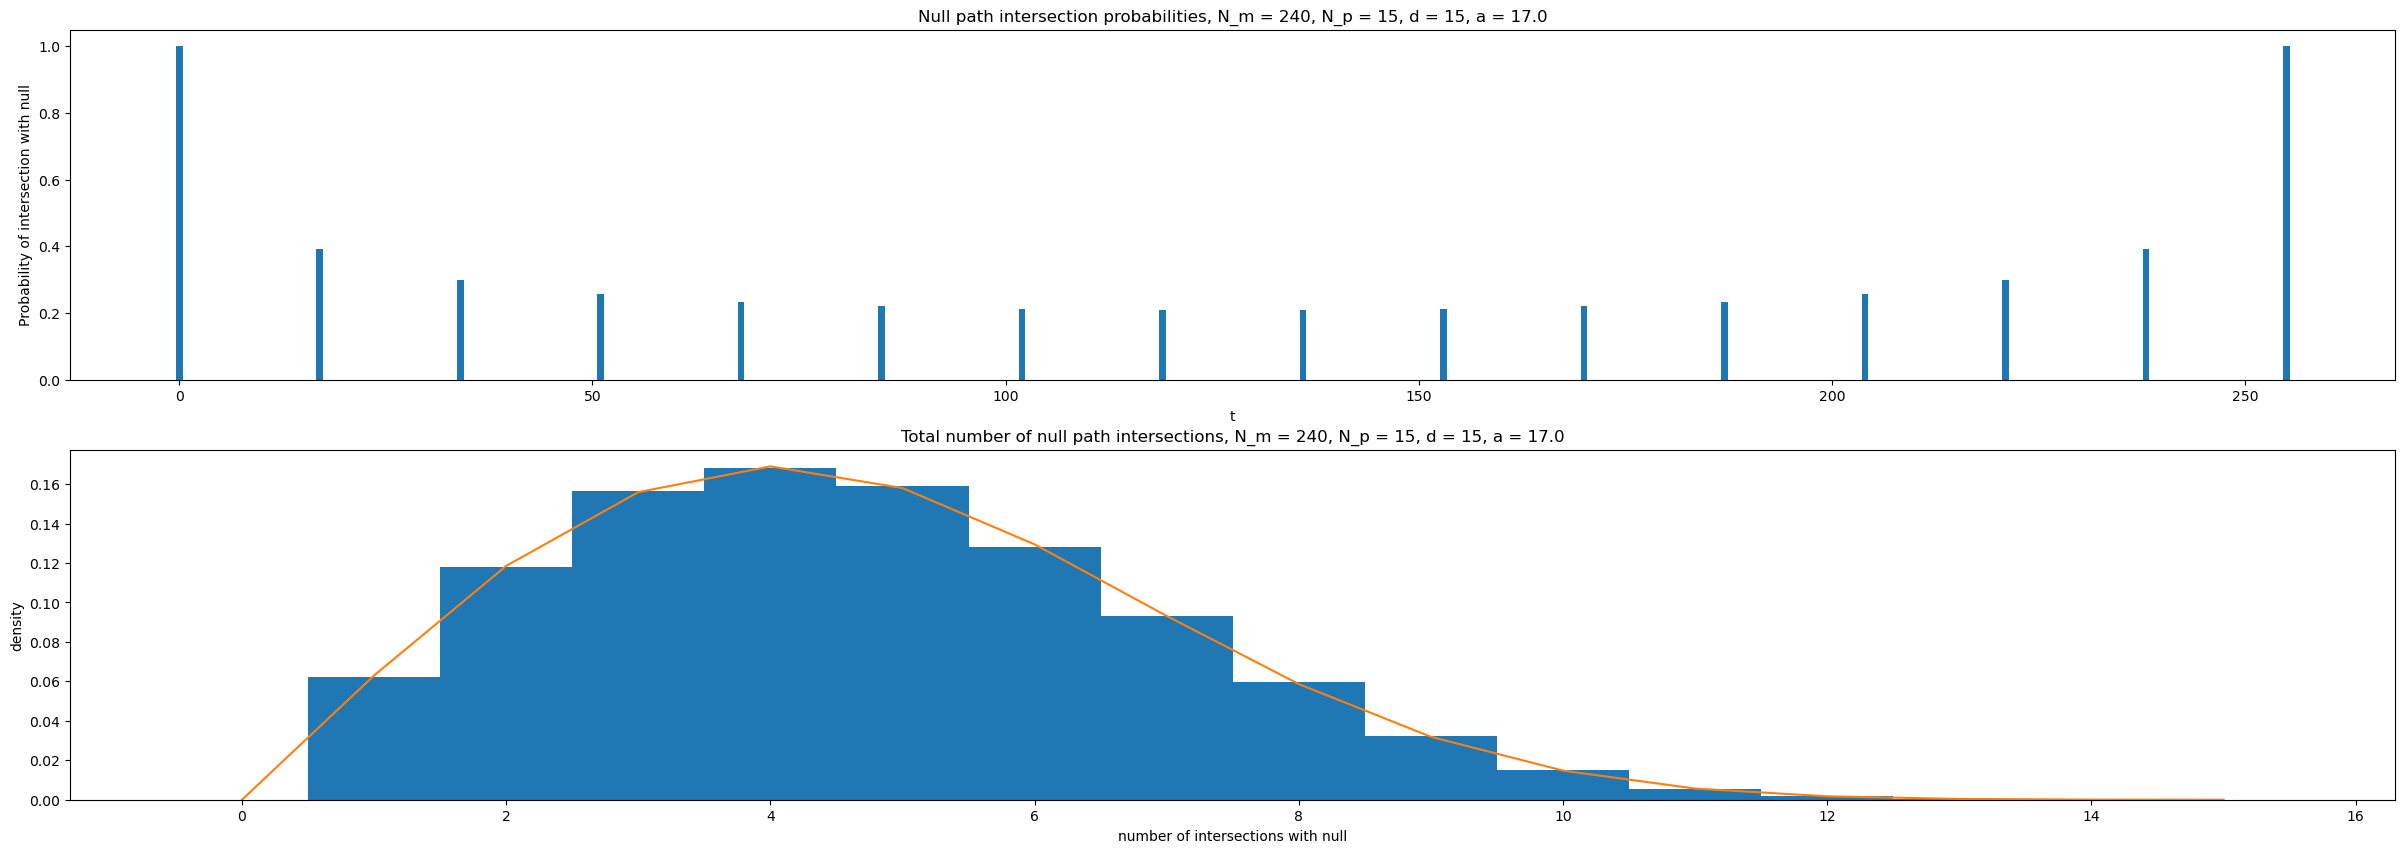

[12 27  6 ... 23  7 14]
Time to complete first loop:  1.8174667358398438
Time to complete second loop:  1.8382246494293213


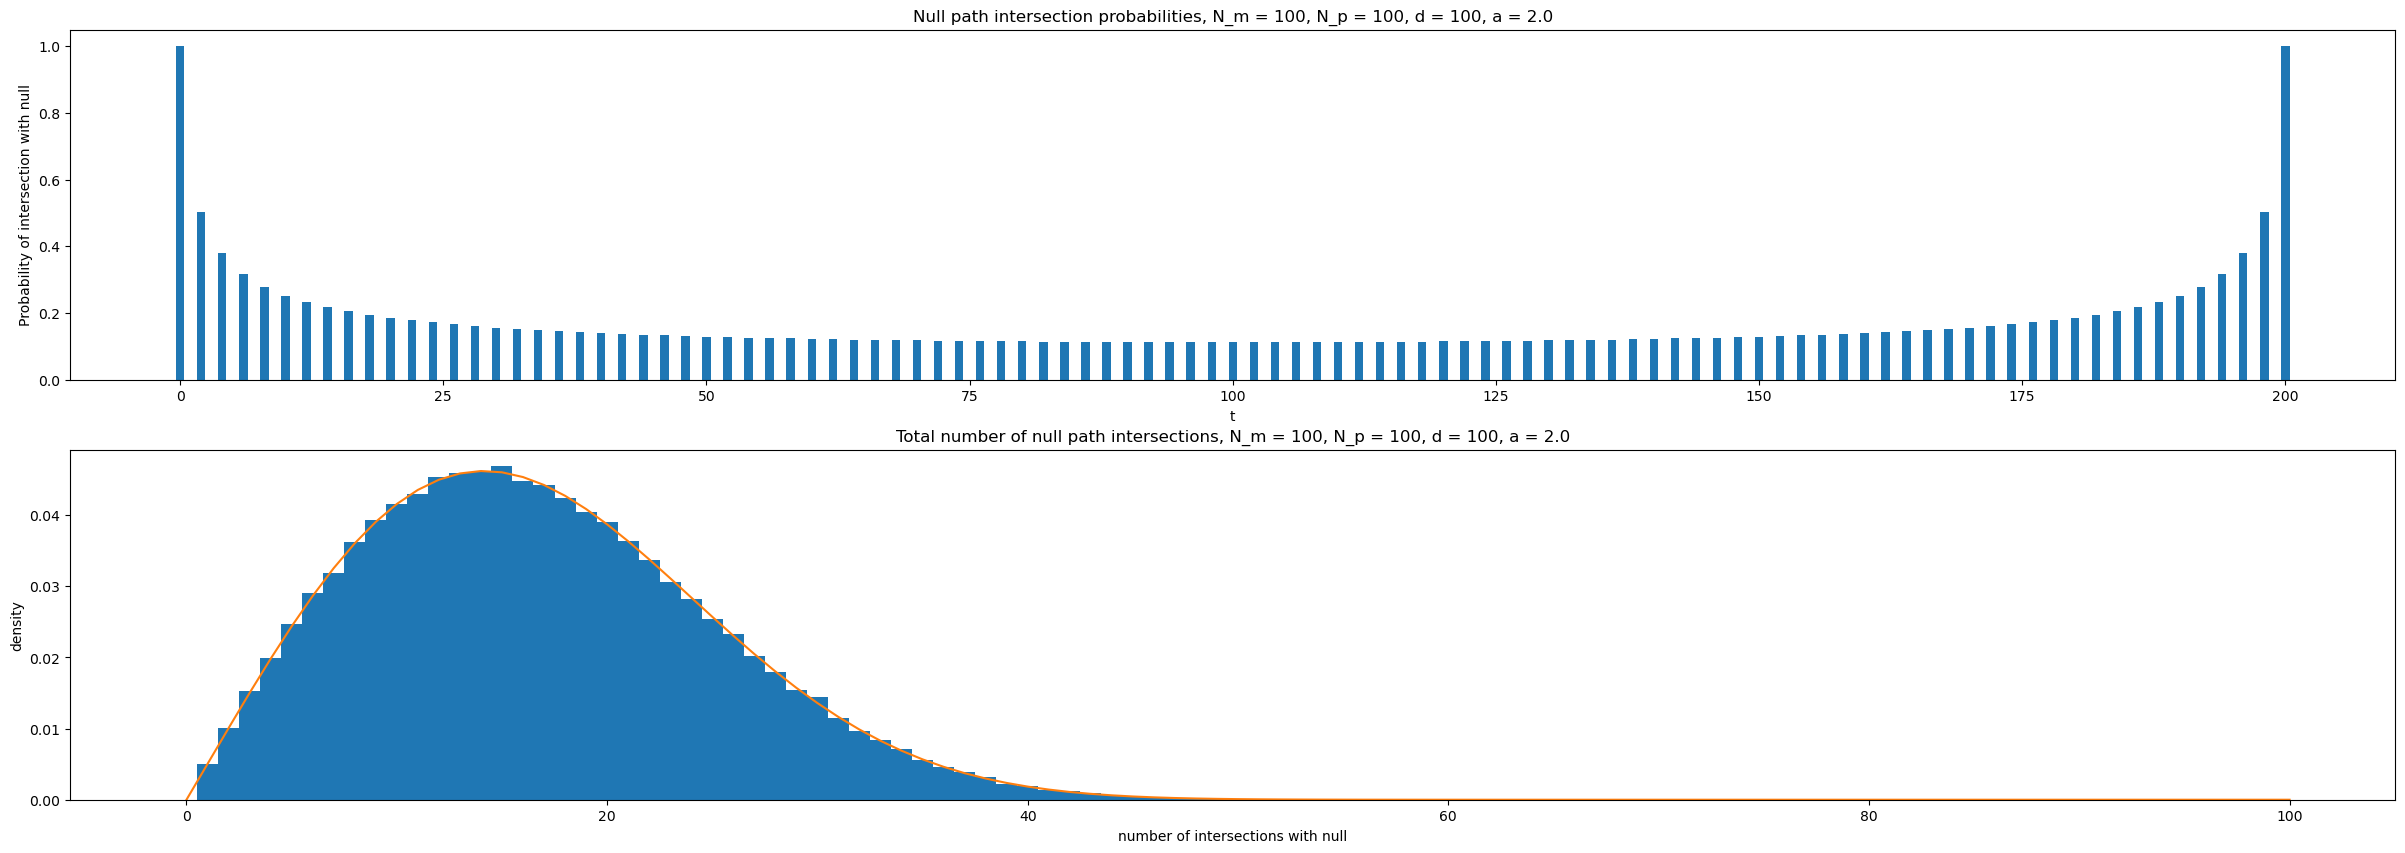

[ 4  6 14 ...  4  4  4]
Time to complete first loop:  6.750884294509888
Time to complete second loop:  7.328903436660767


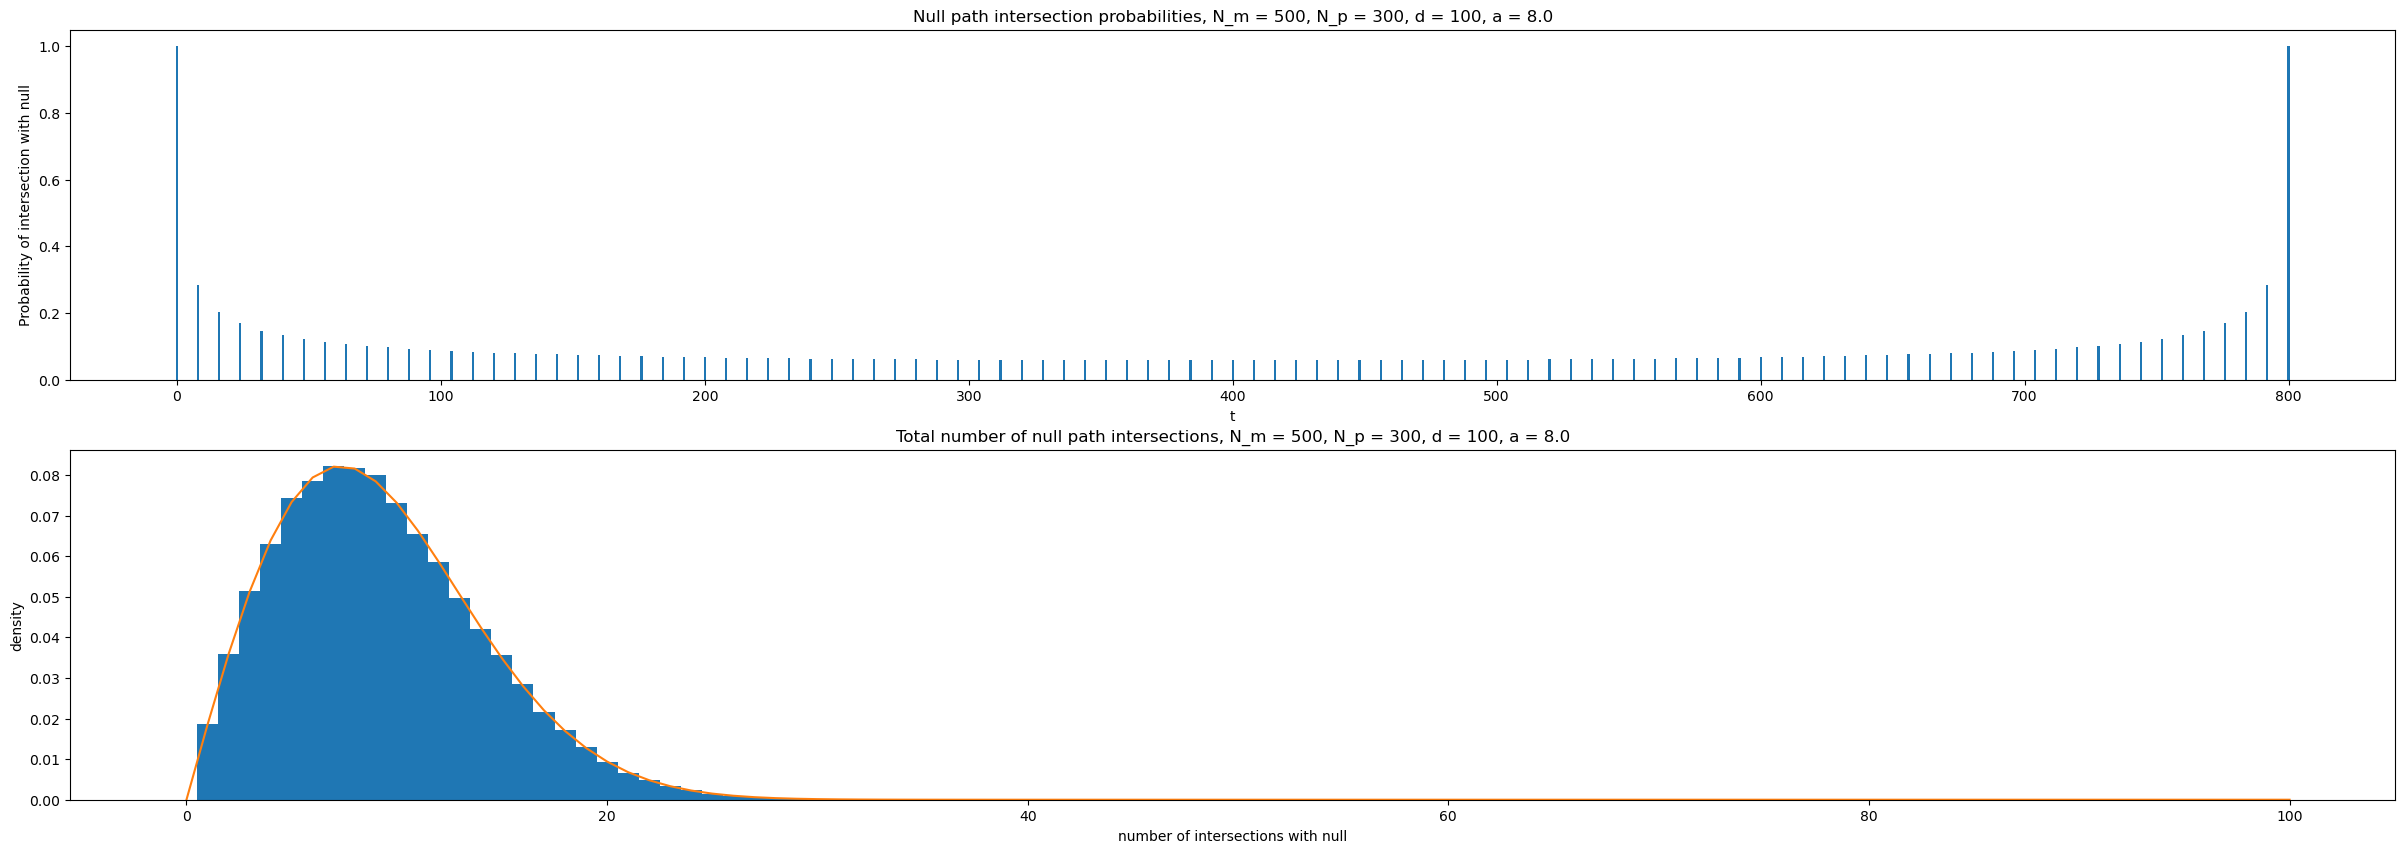

[ 8  8 11 ... 17  7 11]
Time to complete first loop:  5.313462018966675
Time to complete second loop:  5.710773468017578


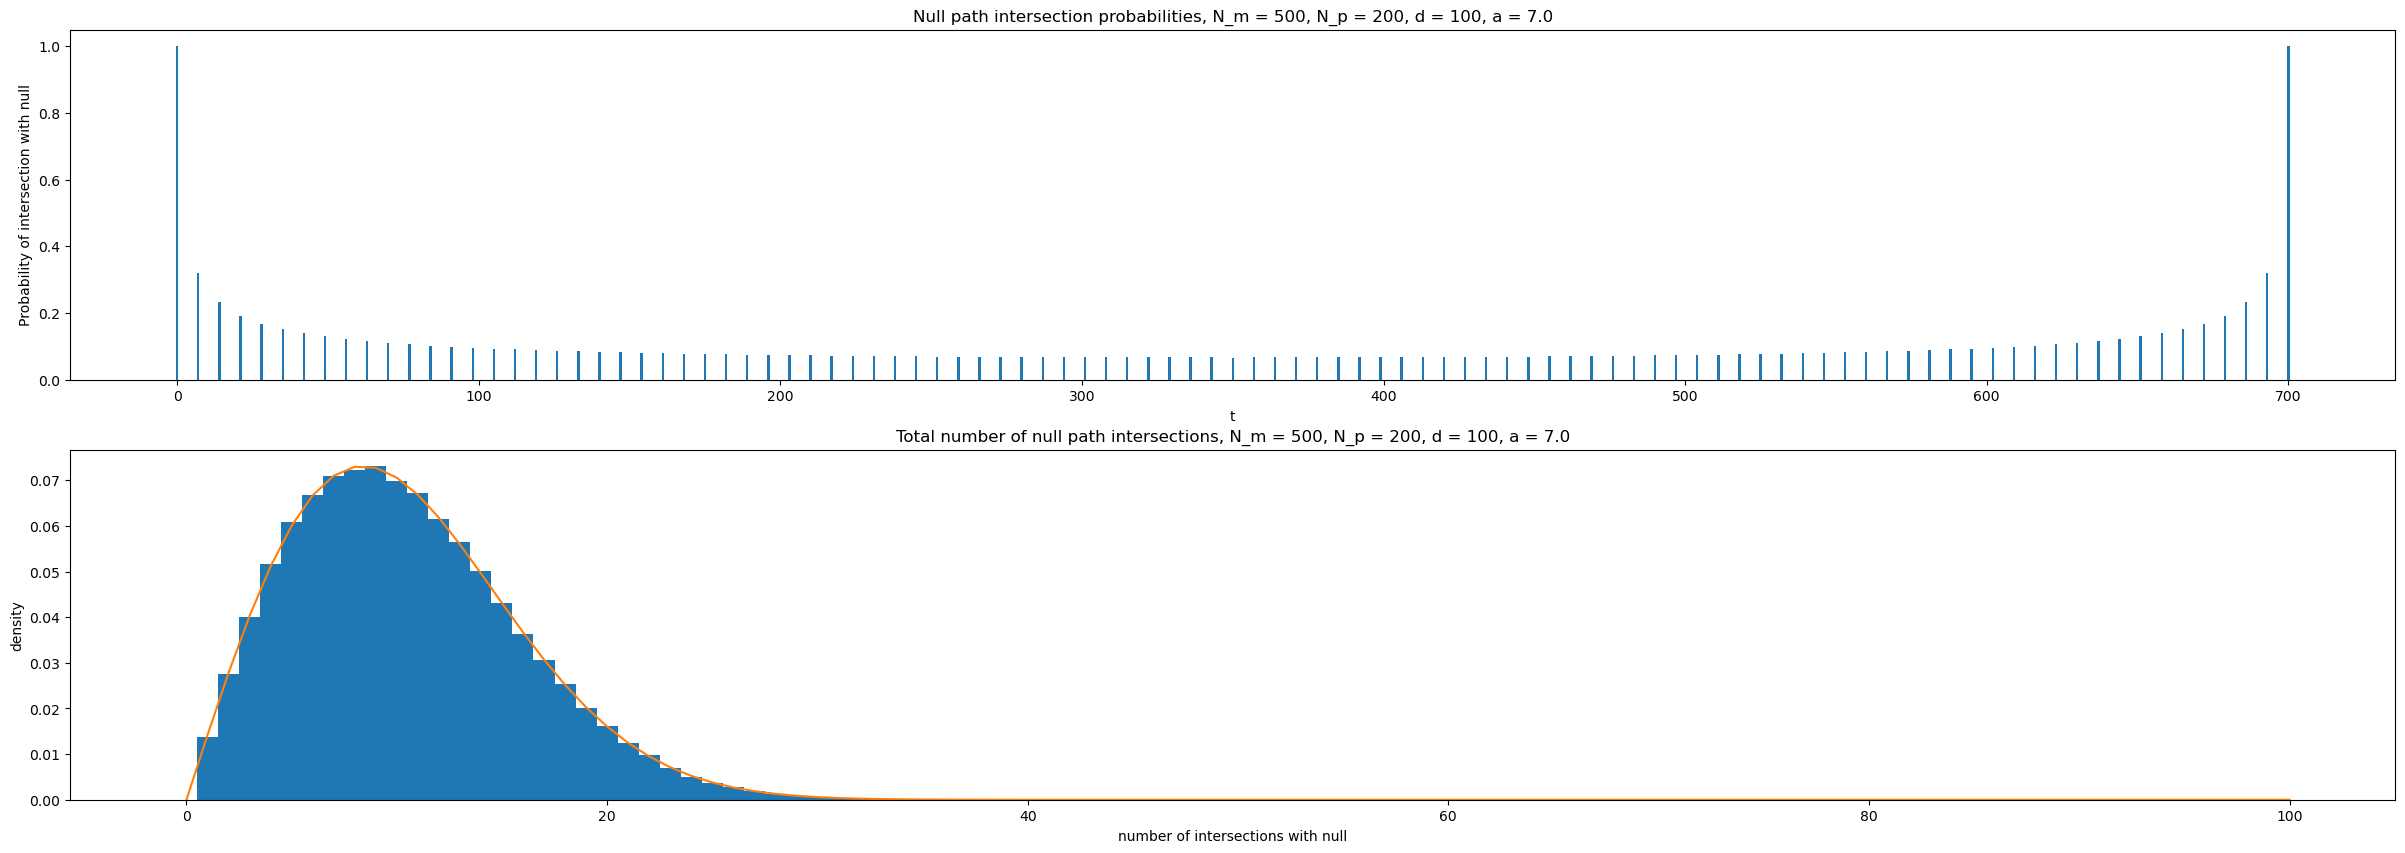

[ 3  9  4 ...  2  3 10]
Time to complete first loop:  4.050610542297363
Time to complete second loop:  4.366348743438721


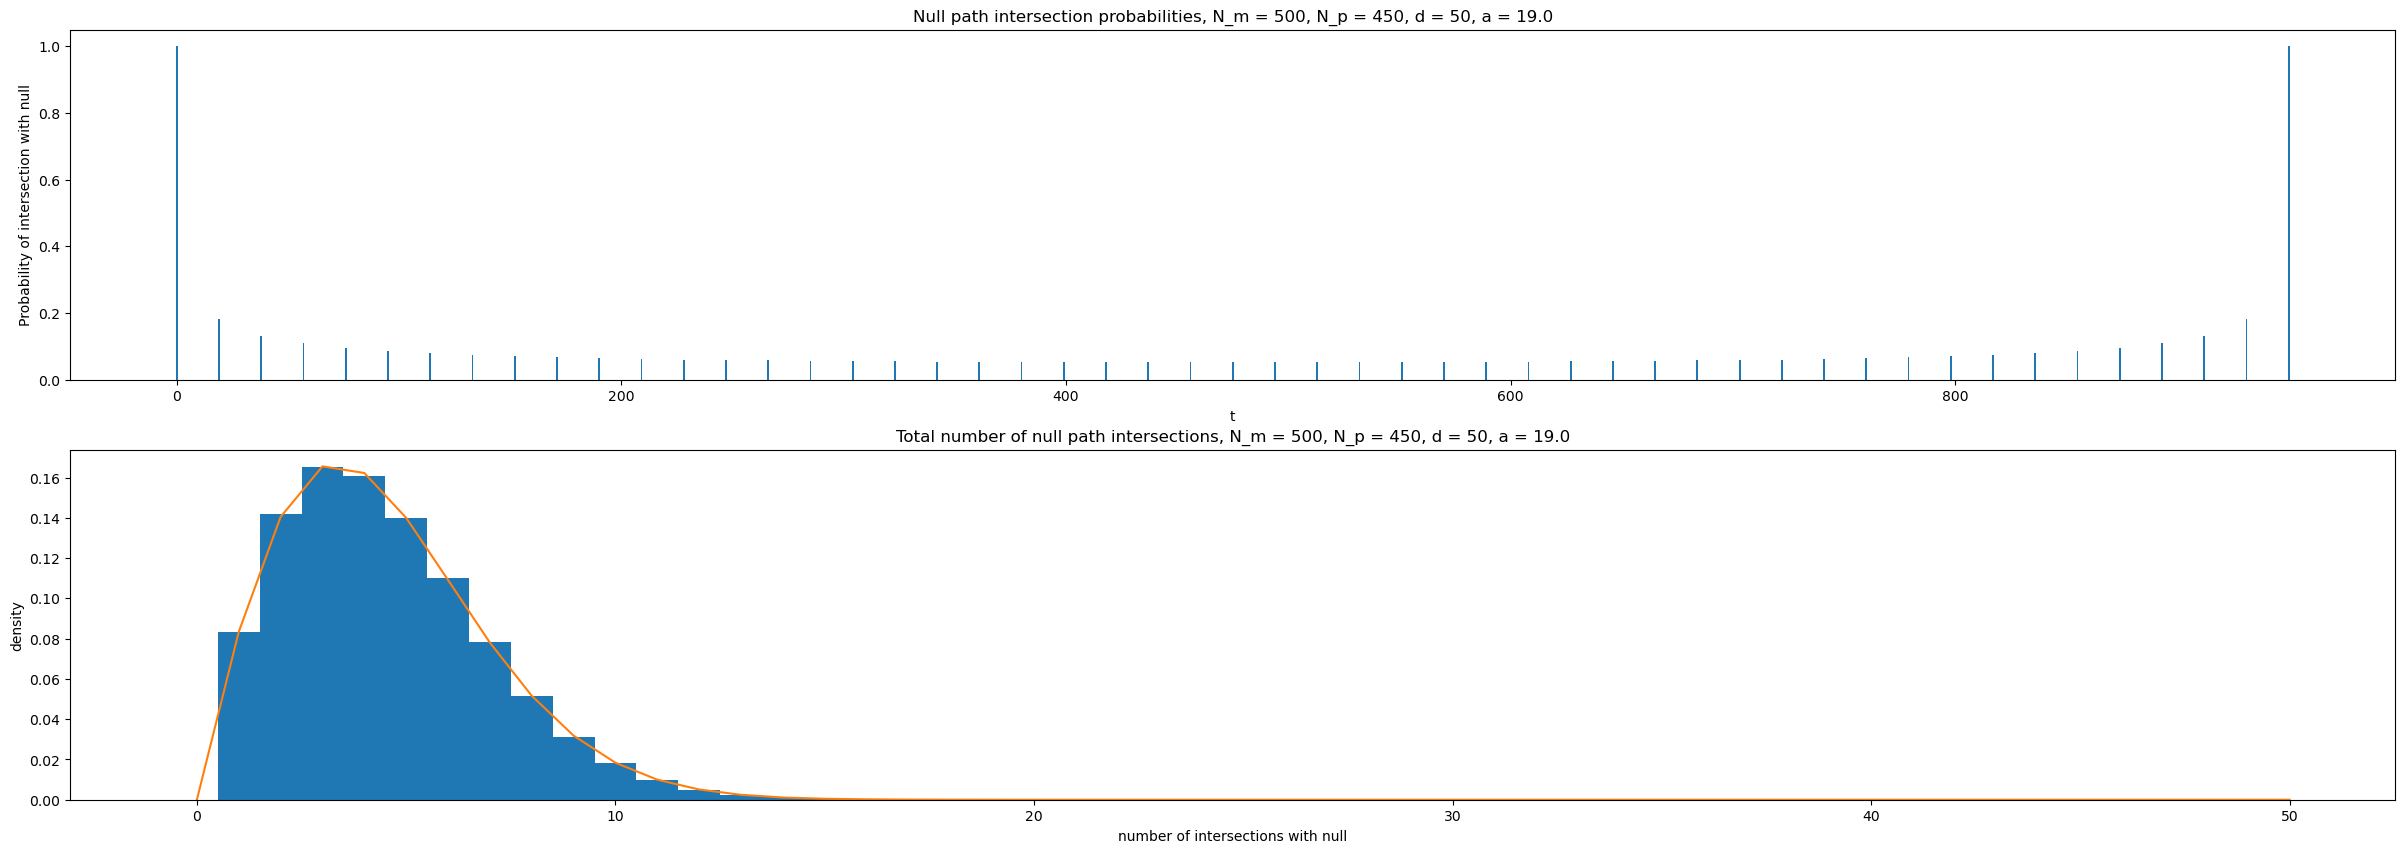

[1 1 1 ... 1 1 1]
Time to complete first loop:  0.13463091850280762
Time to complete second loop:  0.14352917671203613


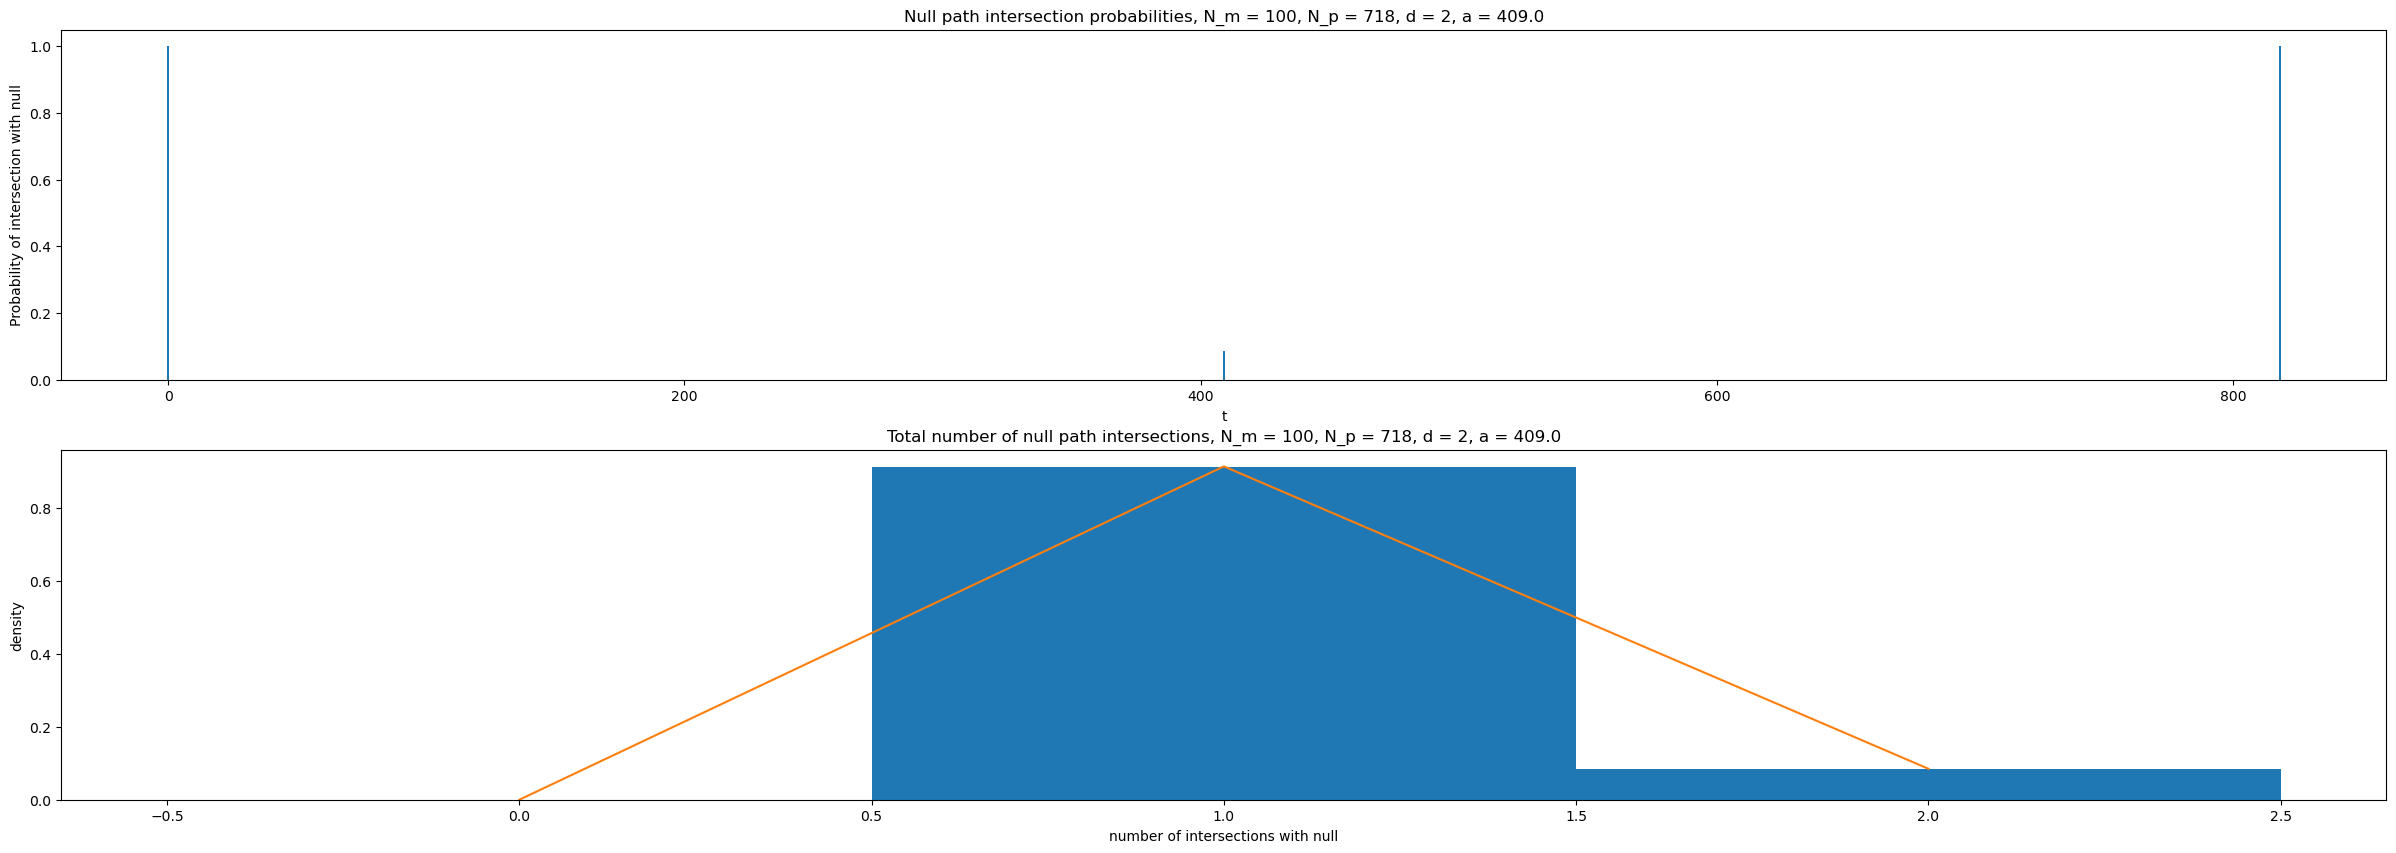

In [ ]:
# Exact intersection probabilities 
# n_ratios = [15] + [i for i in range(1,4)]
# N1 = [15 * 16] + [i * 300 for i in range(1,3)]

N_ps = [15, 100, 300, 200, 450, 718]
N_ms = [15 * 16, 100, 500, 500, 500, 100]

M = 200000

for i in range(len(N_ps)):
    N_p = N_ps[i]
    N_m = N_ms[i]
    N = N_p + N_m

    d = np.gcd(N, N_p)
    a = N / d
    b = N_p / d


    _, inter_number = intersection_density(N_m, N_p, M)
    print(inter_number)
    
    fig, axs = plt.subplots(2,1)
    fig.set_figwidth(30)
    fig.set_figheight(10)
    x = np.arange(N+1)
    axs[0].bar(x,null_intersection_exact(N_m, N_p))
    axs[0].set_title(f"Null path intersection probabilities, N_m = {N_m}, N_p = {N_p}, d = {d}, a = {a}")
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("Probability of intersection with null")
    
    axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
    axs[1].set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, d = {d}, a = {a}")
    axs[1].set_xlabel("number of intersections with null")
    axs[1].set_ylabel("density")


    # print(d)
    # print(N/n_ratio)
    # print(N / (N/d - 1))
    
    if int(N / (N/d - 1)) >= 2:
        # axs[1].plot(np.arange(k+1), intersect_num_dp(int(N / (N/d - 1) / 2)*2, k))
        # axs[1].plot(np.arange(k+1) * 2 / a, intersect_num_dp(N_m * 2, k) * a / 2)
        axs[1].plot(intersect_num_dp(N_m, N_p, K = 60))

    plt.show()

    del inter_number
    gc.collect()
    cp._default_memory_pool.free_all_blocks()

In [56]:
def heat(N_ms, N_ps):
    means = np.zeros([len(N_ps), len(N_ms)])
    for j in range(len(N_ms)):
        N_m = N_ms[j]
        for i in range(len(N_ps)):
            N_p = N_ps[i]
            probs = null_intersection_exact(N_m,N_p)
            means[i,j] = (np.sum(probs)-1) # / (N_m + N_p) # keeps 
    return means

def heatvar(N_ms, N_ps, M=10000):
    vars = np.zeros([len(N_ps), len(N_ms)])
    for j in range(len(N_ms)):
        N_m = N_ms[j]
        for i in range(len(N_ps)):
            N_p = N_ps[i]
            _, intrsct_nums = intersection_density(N_m, N_p, M)
            vars[i,j] = cp.var(intrsct_nums)
    return vars

In [195]:
# N_ms = np.arange(1,201) # 51 visually interesting
# N_ps = np.arange(1,201) 

# y = heat(N_ms,N_ps)
# x = heatvar(N_ms,N_ps)
# np.save('x200', x)
# np.save('y200', y)
x = np.load('x200.npy')
y = np.load('y200.npy')

z = np.sqrt(x)/y


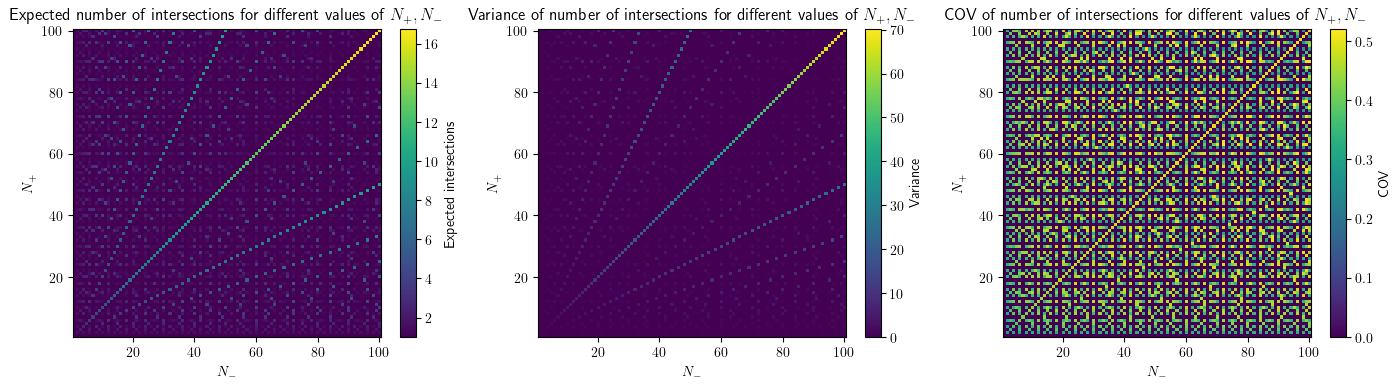

In [218]:
B_ms = [1,100]
B_ps = [1,100]
fig, ax = plt.subplots(1,3)
fig.set_figwidth(17)
fig.set_figheight(4)

im_mean = ax[0].imshow(y[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear')
ax[0].set_xlabel('$N_-$')
ax[0].set_ylabel('$N_+$')
ax[0].set_title(f"Expected number of intersections for different values of $N_+,N_-$")
plt.colorbar(mappable=im_mean, label = "Expected intersections")

im_var = ax[1].imshow(x[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear')
ax[1].set_xlabel('$N_-$')
ax[1].set_ylabel('$N_+$')
ax[1].set_title("Variance of number of intersections for different values of $N_+,N_-$")
plt.colorbar(mappable=im_var, label="Variance")

im_cov = ax[2].imshow(z[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear')
ax[2].set_xlabel('$N_-$')
ax[2].set_ylabel('$N_+$')
ax[2].set_title("COV of number of intersections for different values of $N_+,N_-$")
plt.colorbar(mappable=im_cov,label="COV")
plt.savefig(f"Intersection heatmap {B_ms[-1],B_ps[-1]}",backend="pgf")
plt.show()

[[  1   1   1 ...   1   1   1]
 [  1   2   1 ...   2   1   2]
 [  1   1   3 ...   3   1   1]
 ...
 [  1   2   3 ... 198   1   2]
 [  1   1   1 ...   1 199   1]
 [  1   2   1 ...   2   1 200]]


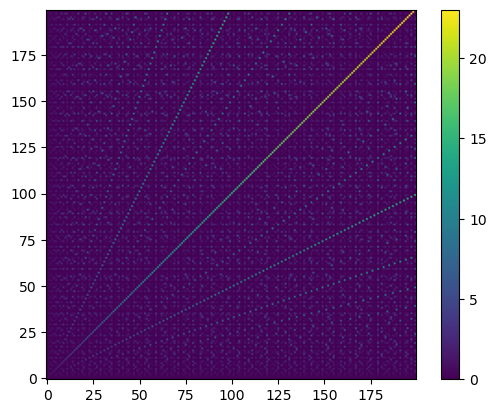

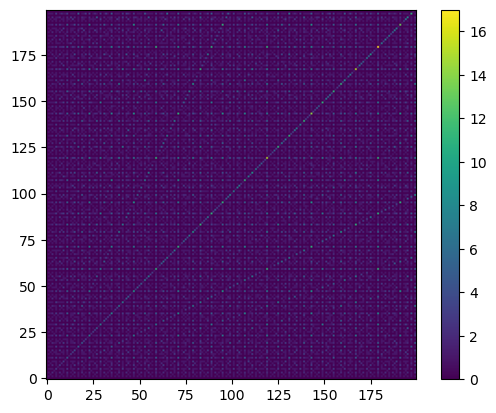

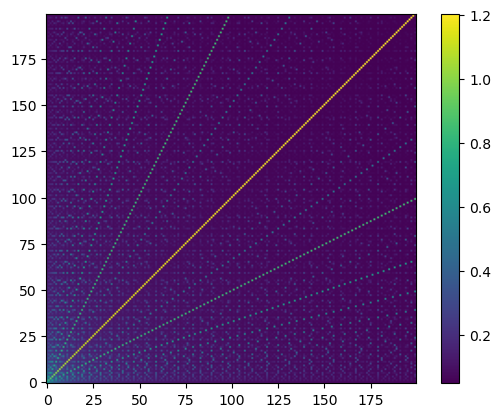

In [679]:
gcds = cp.gcd(cp.array([cp.array(N_ms)]).T, cp.array(N_ps))
lcms = cp.lcm(cp.array([cp.array(N_ms)]).T, cp.array(N_ps))

print(gcds)

def factors(x):
    nums = cp.array([[cp.arange(1,cp.max(x)+1)]]).T
    rem = cp.remainder(x,nums)
    return cp.sum(cp.where(rem == 0,1,0),axis=0)

facs = factors(gcds)

im_facs = plt.imshow((gcds**(3/5)).get()-1, origin='lower')
plt.colorbar(mappable=im_facs)
plt.show()
im_facs = plt.imshow(facs.get()-1, origin='lower')
plt.colorbar(mappable=im_facs)
plt.show()

Ns = cp.array([cp.array(N_ms)]).T + cp.array(N_ps)
im_facs = plt.imshow(y/((cp.sqrt(Ns)).get()), origin='lower')
plt.colorbar(mappable=im_facs)
plt.show()

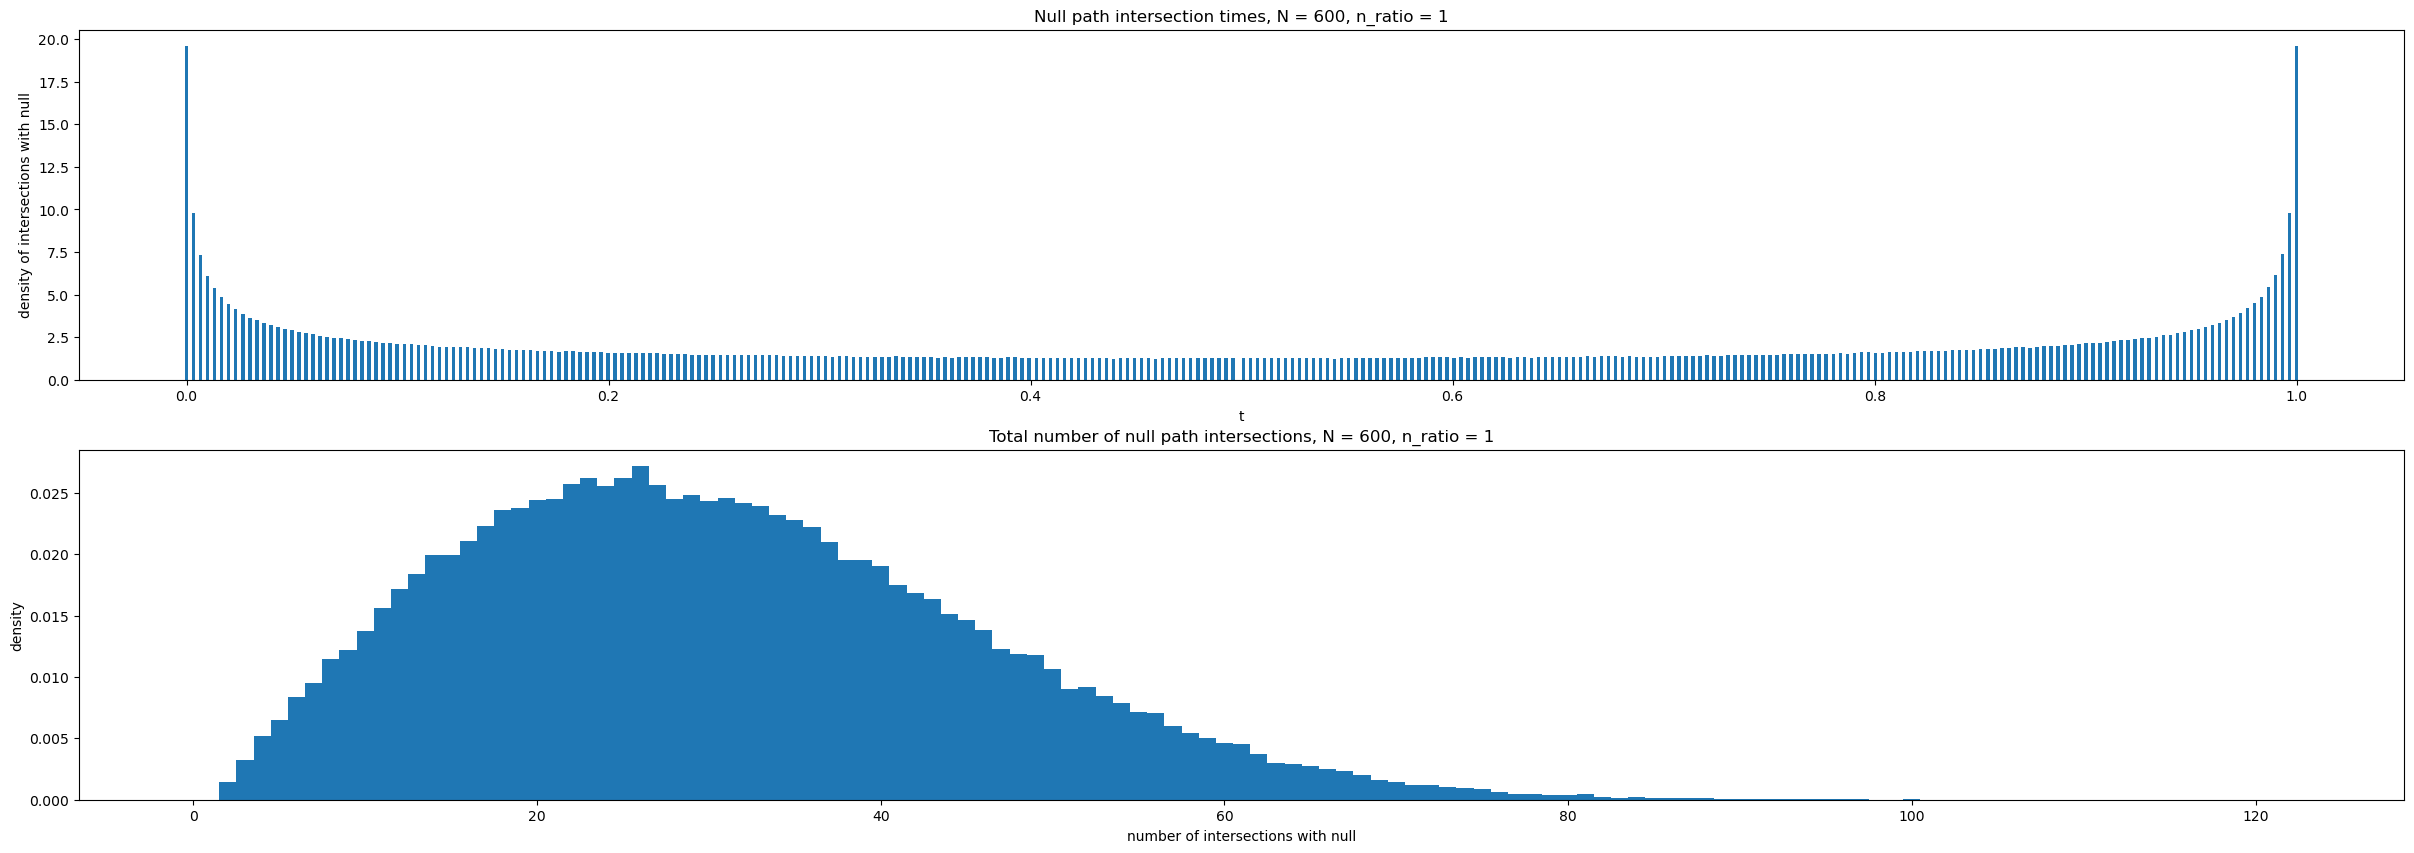

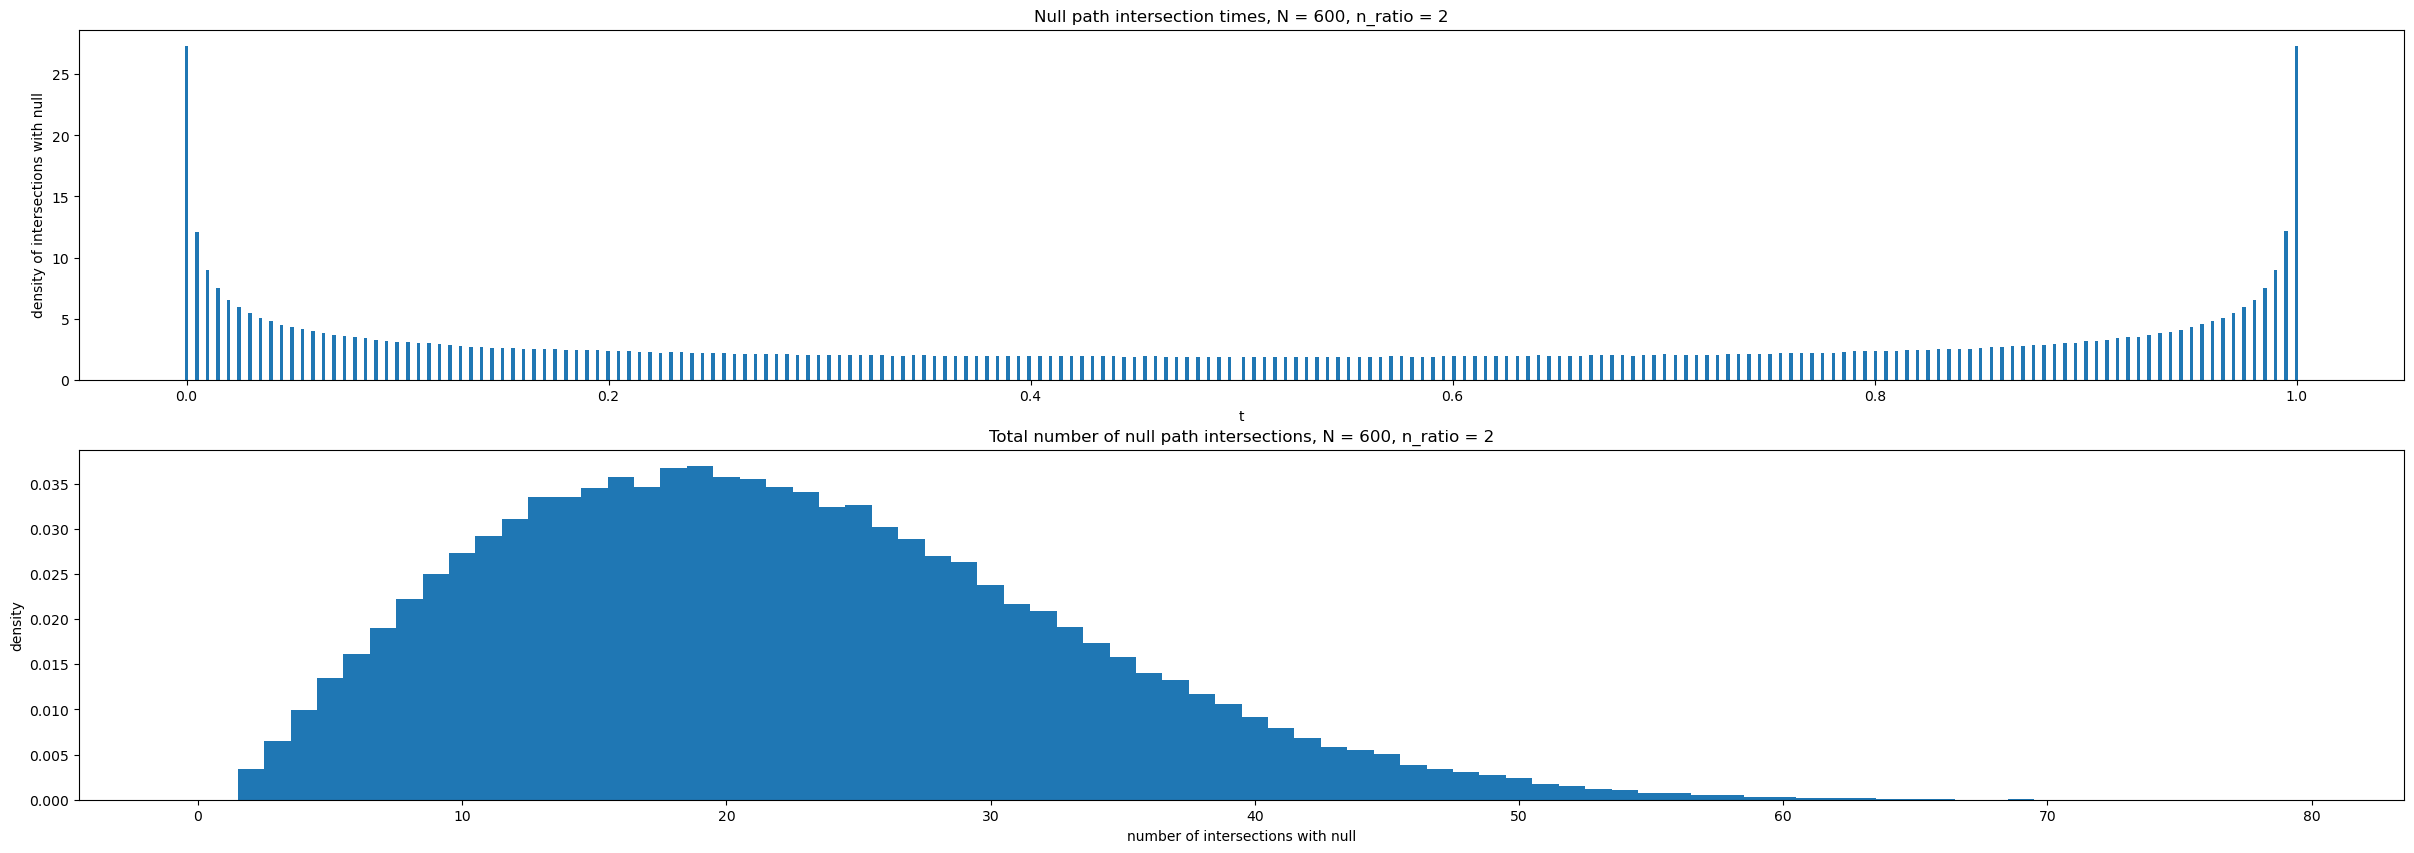

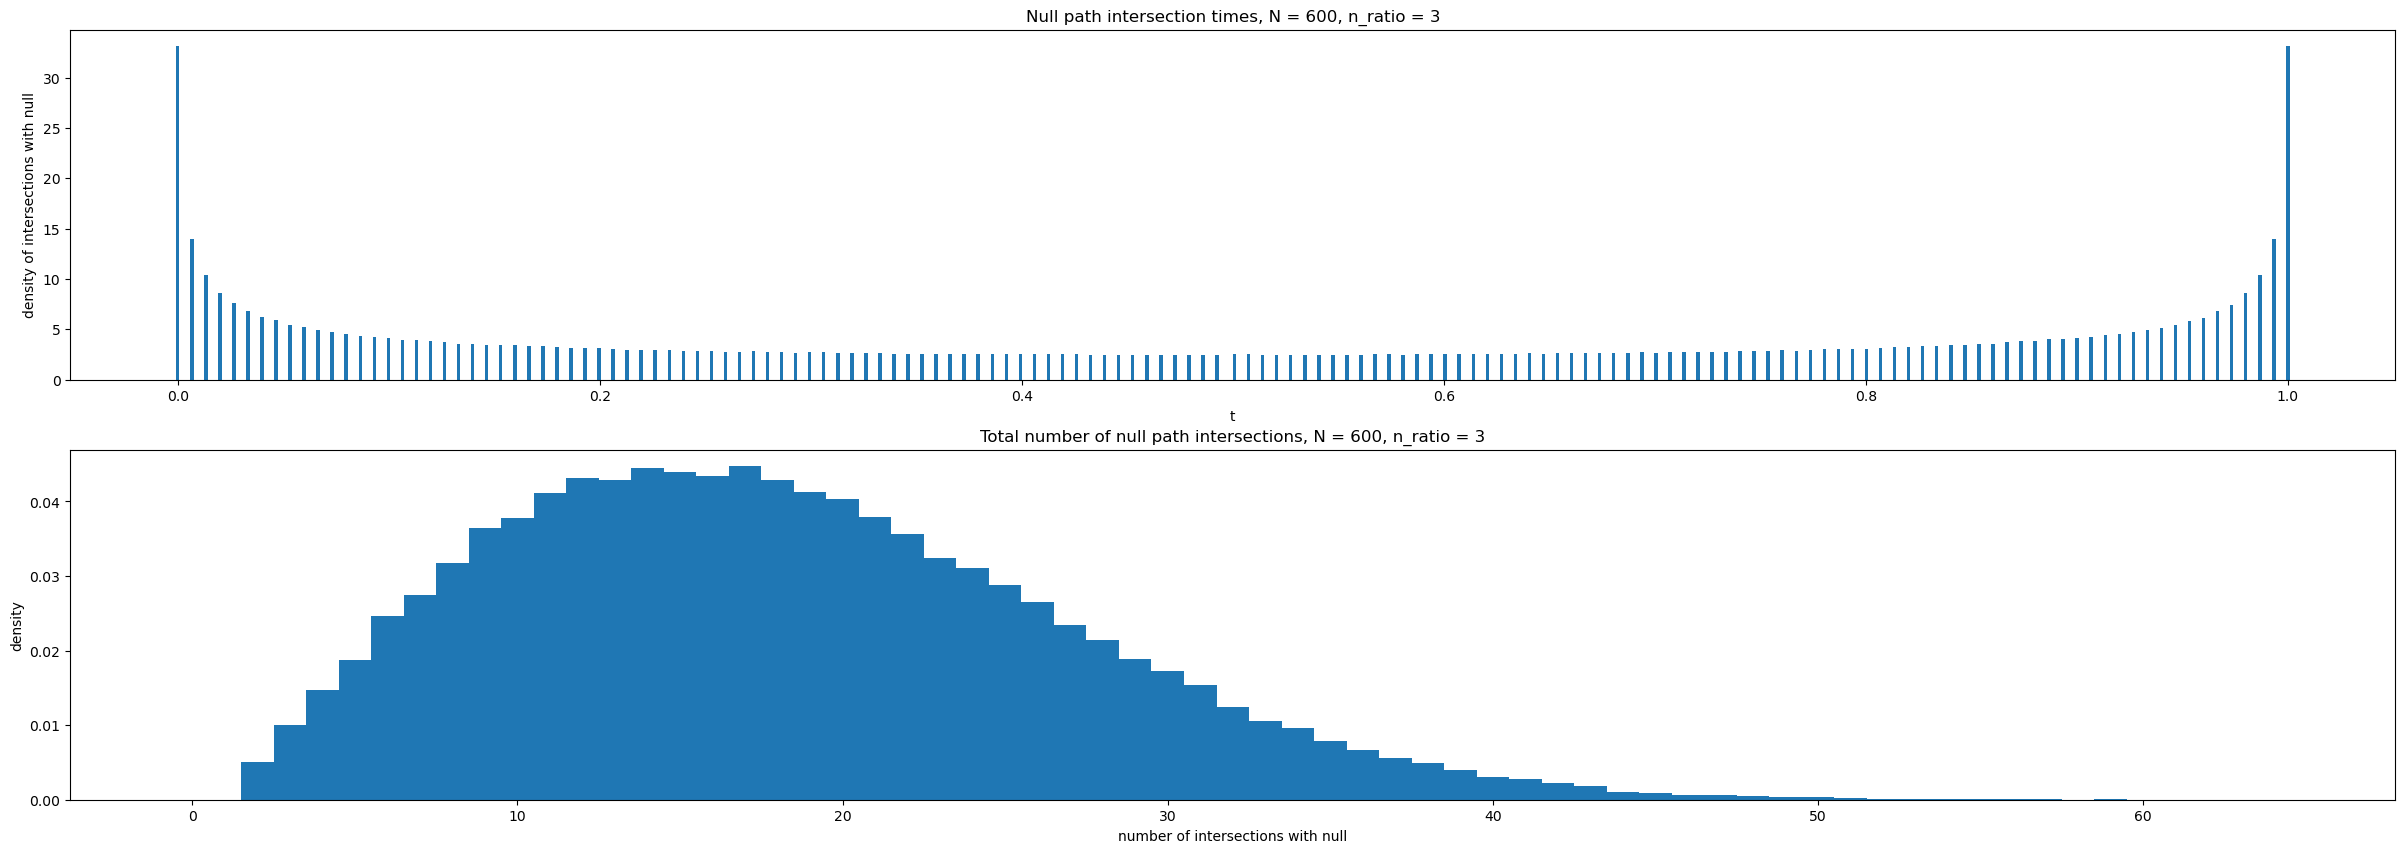

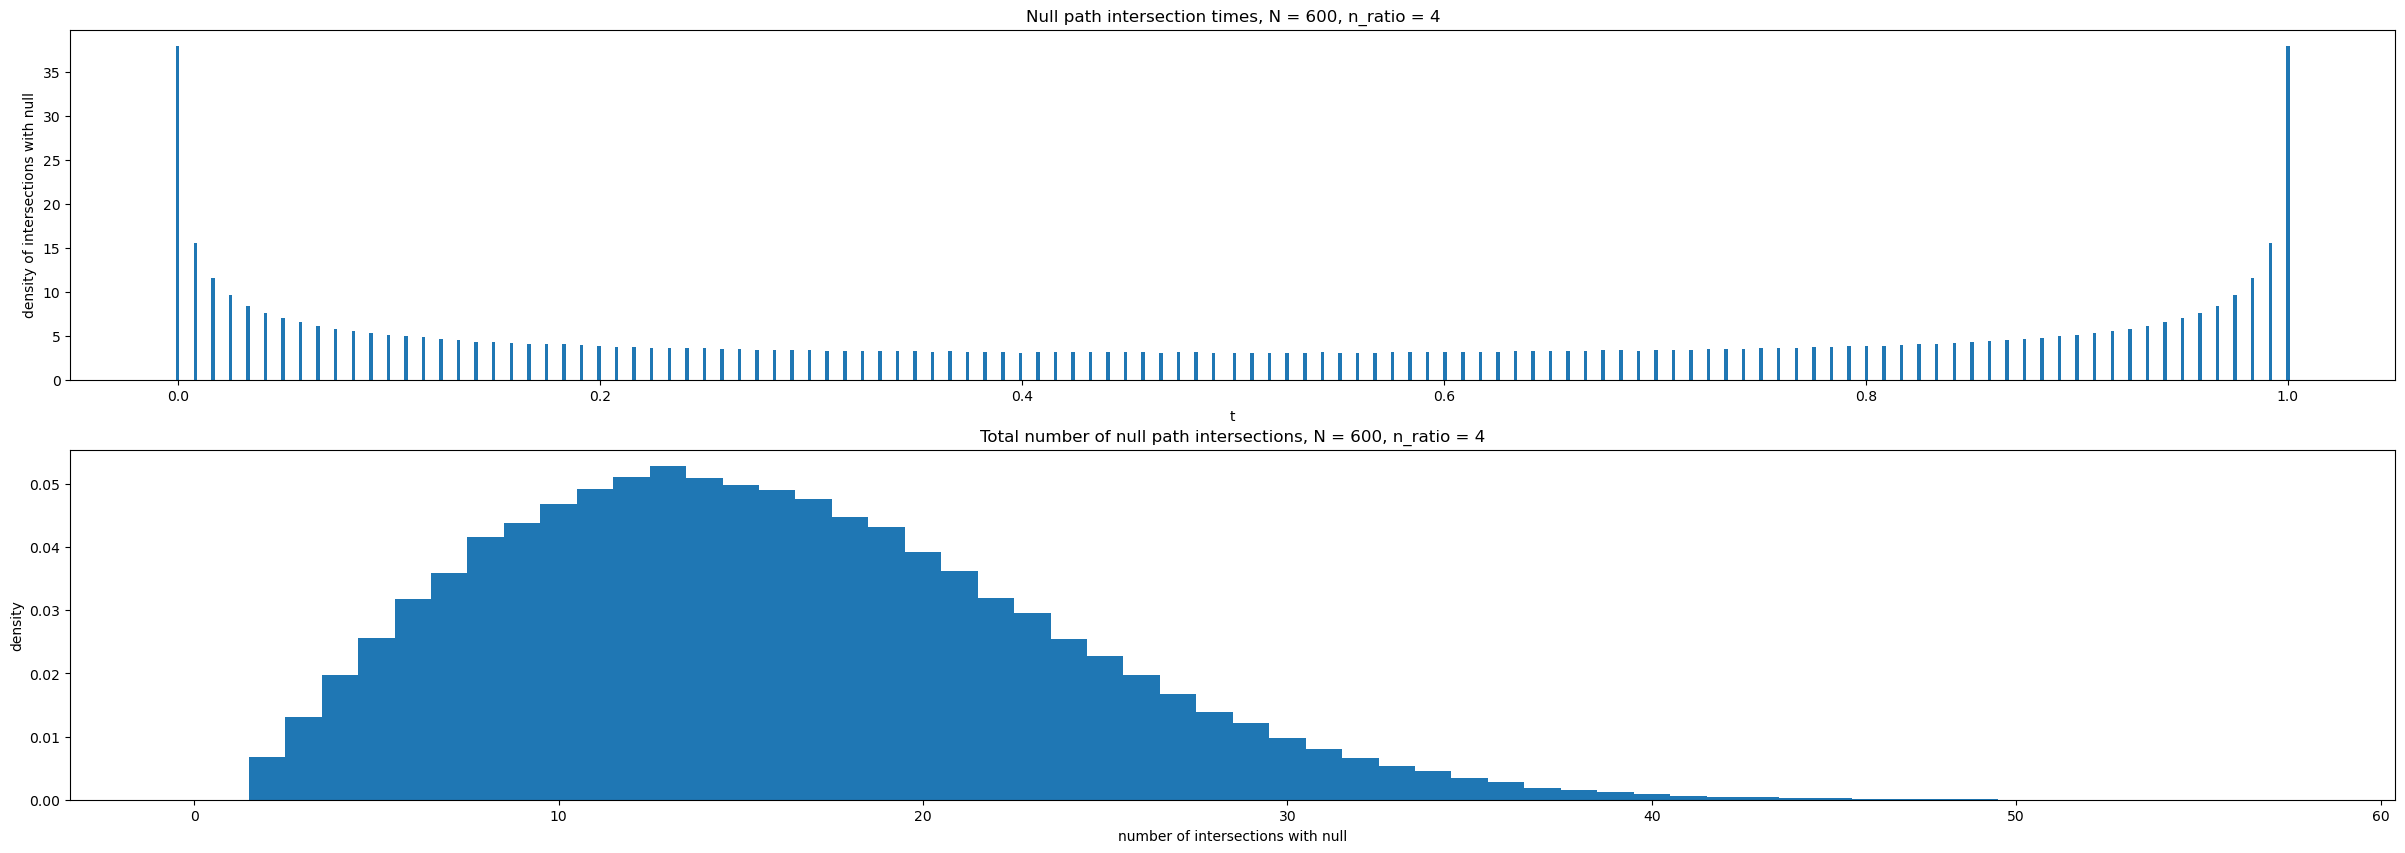

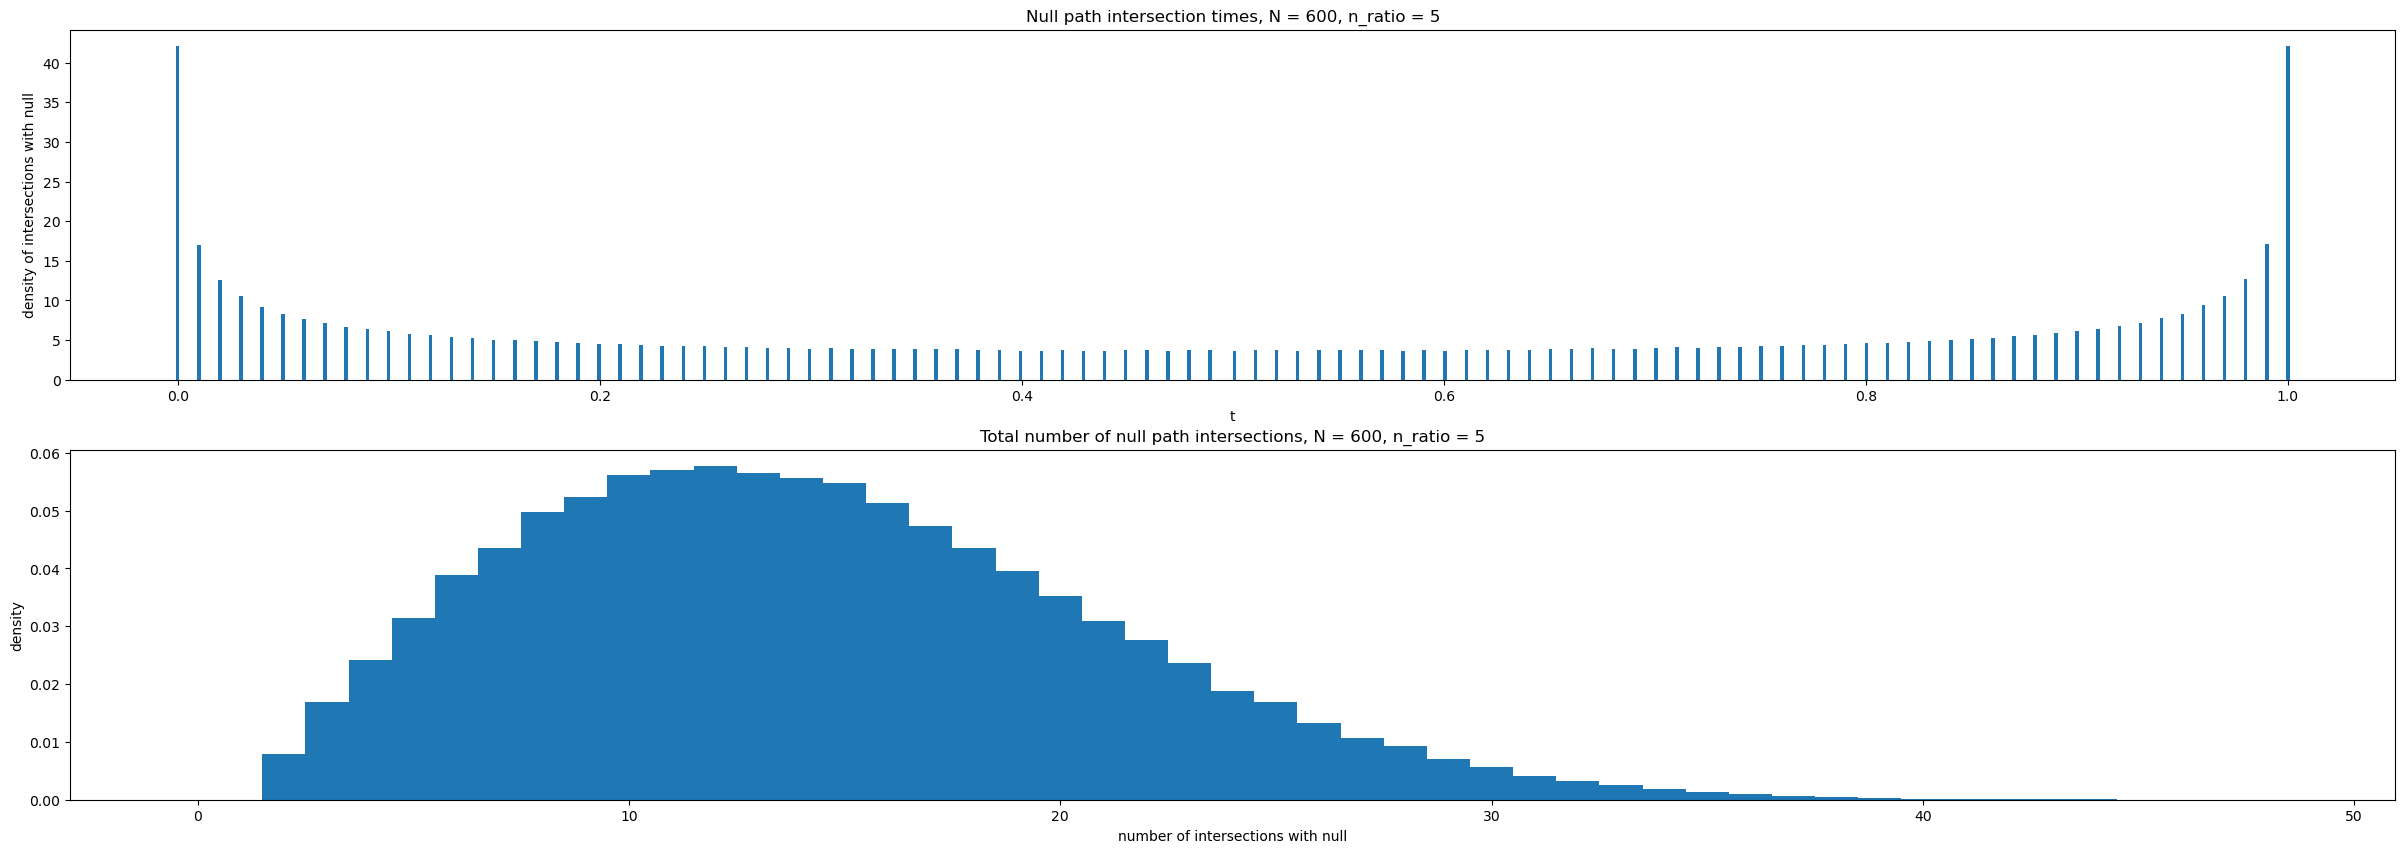

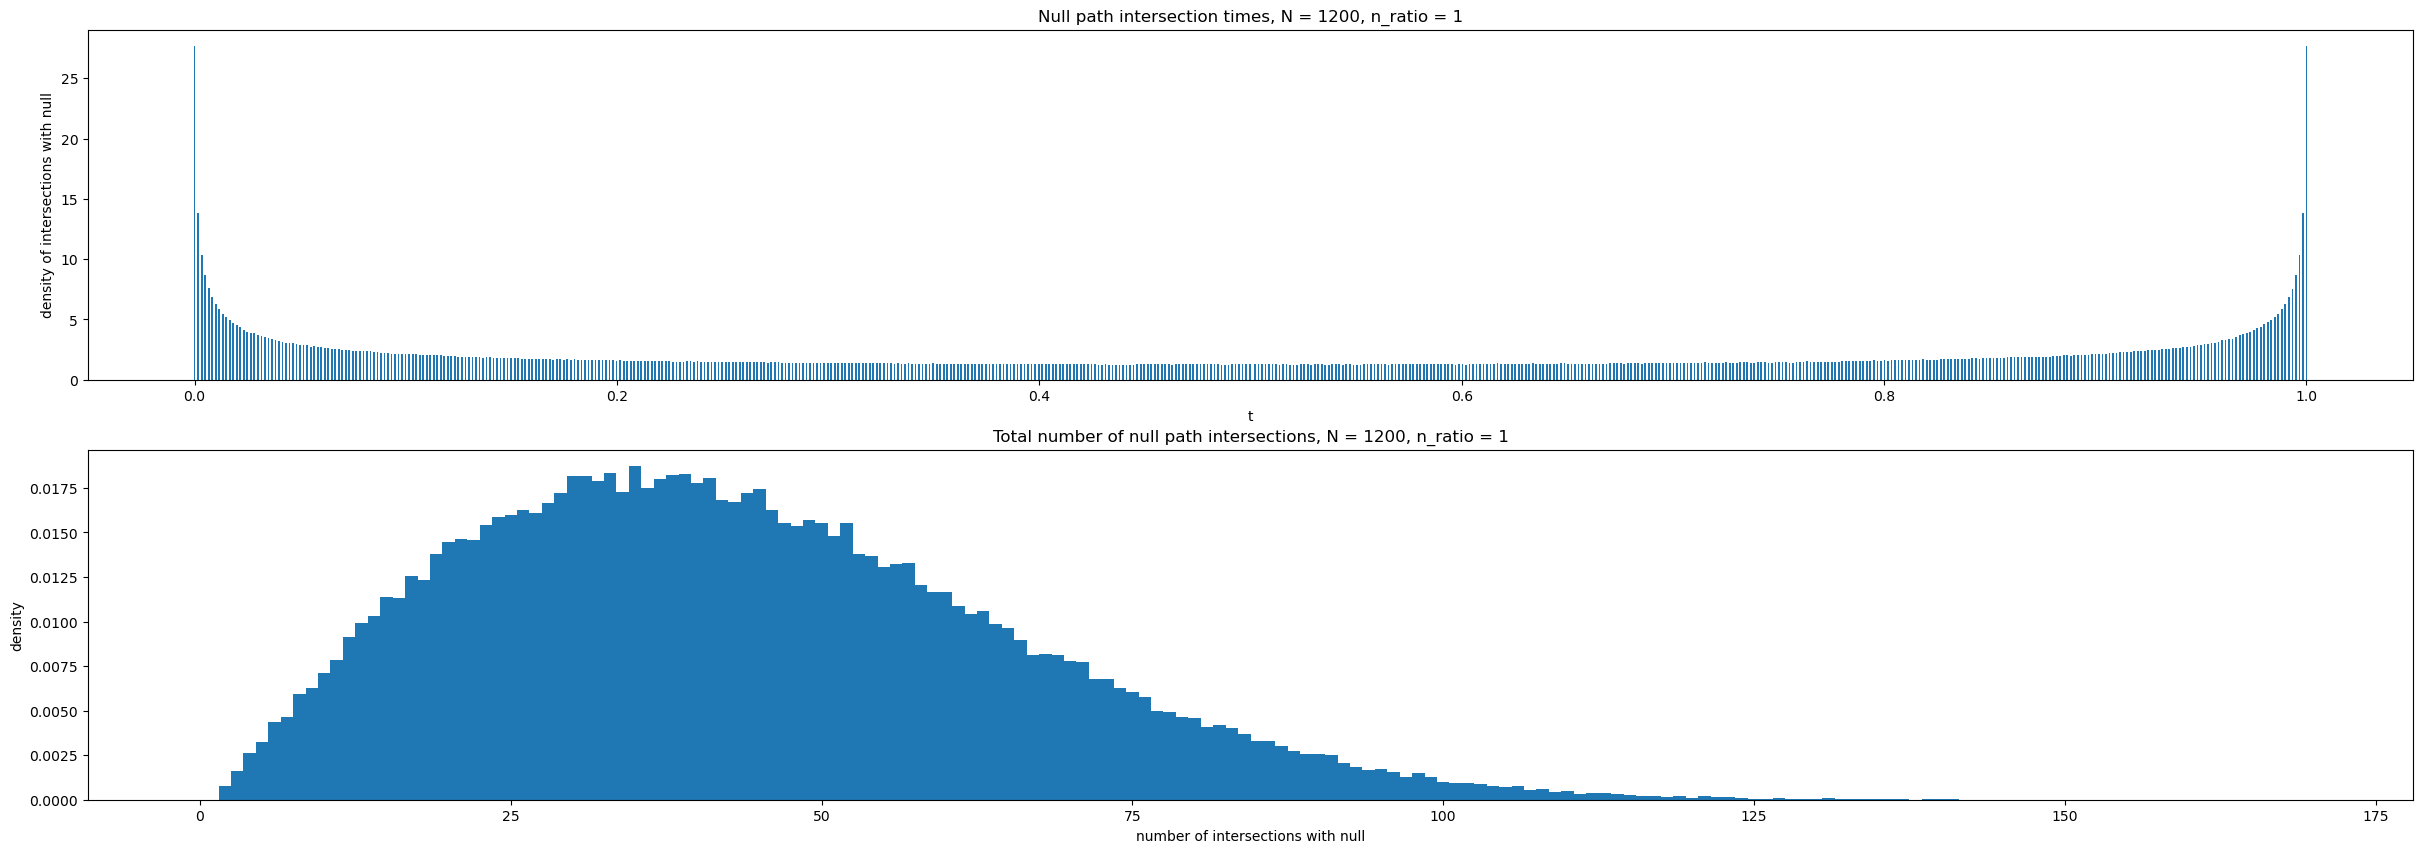

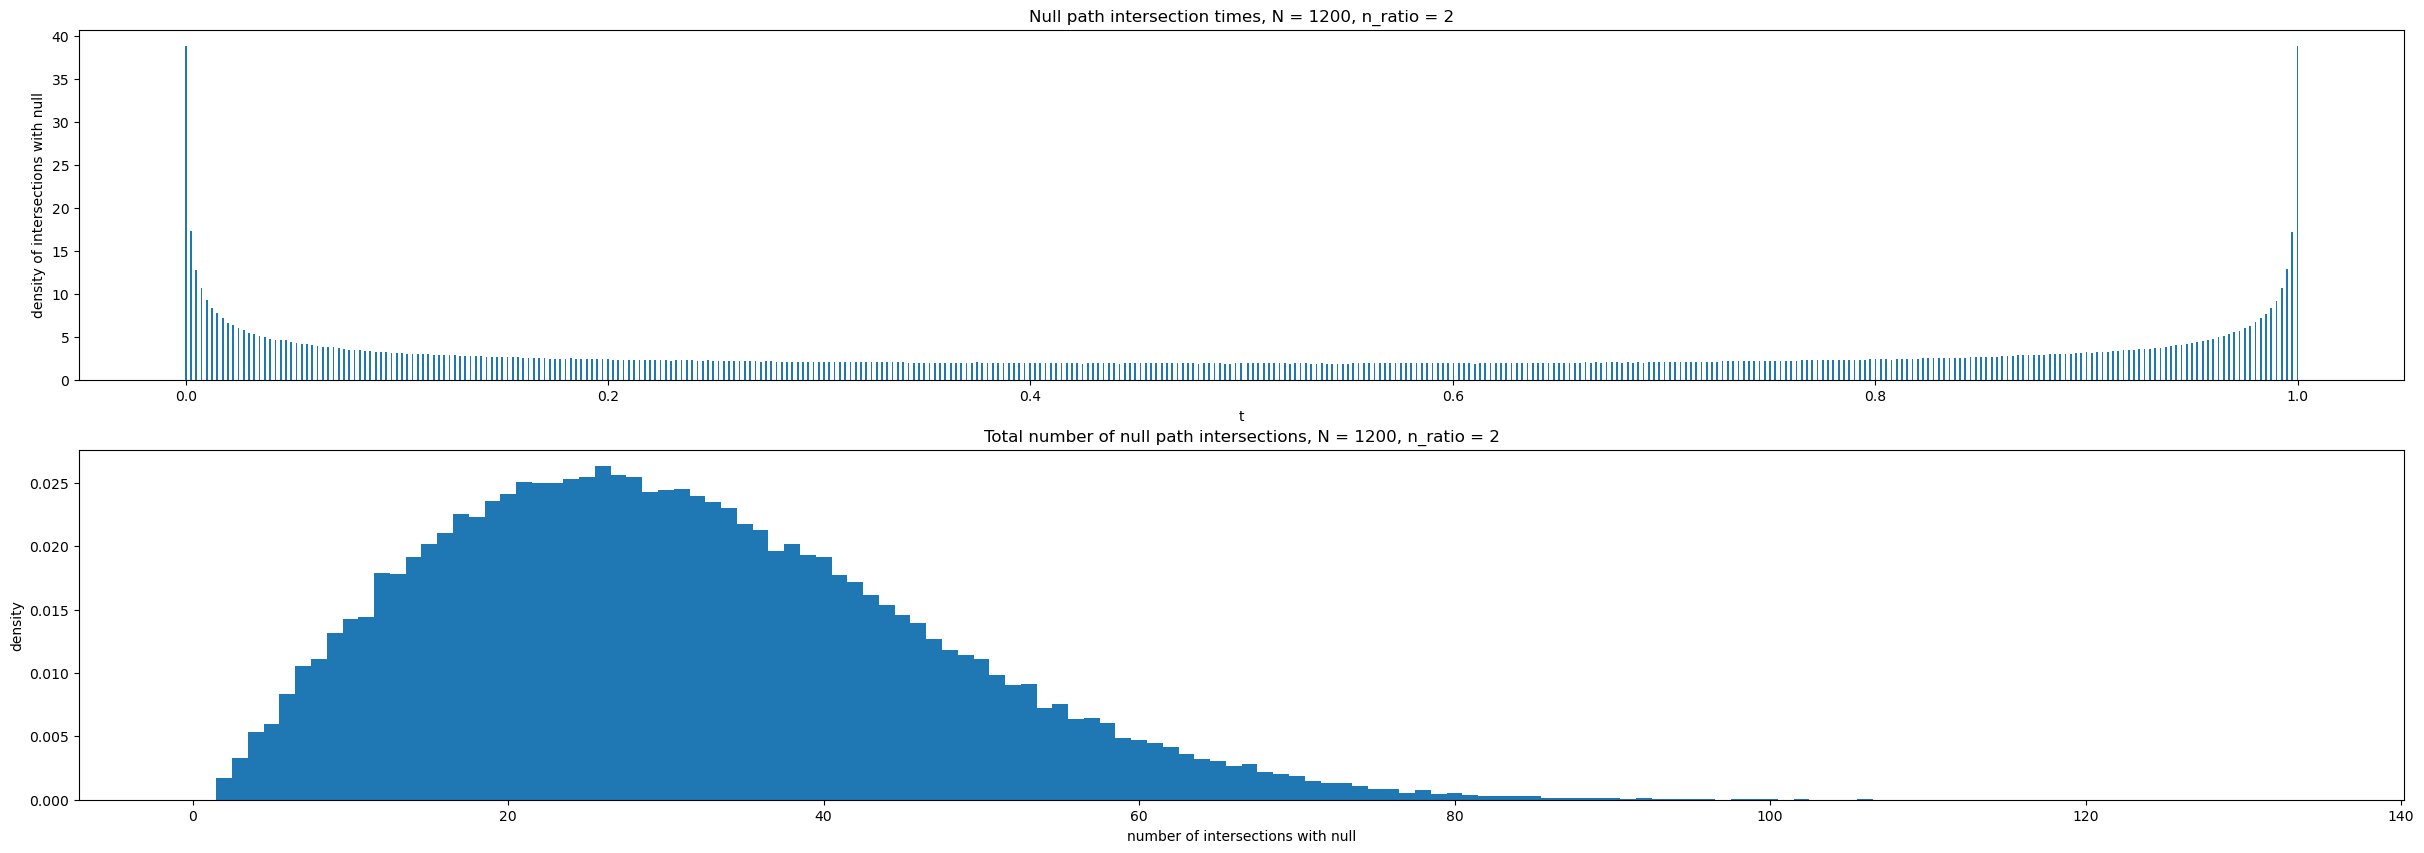

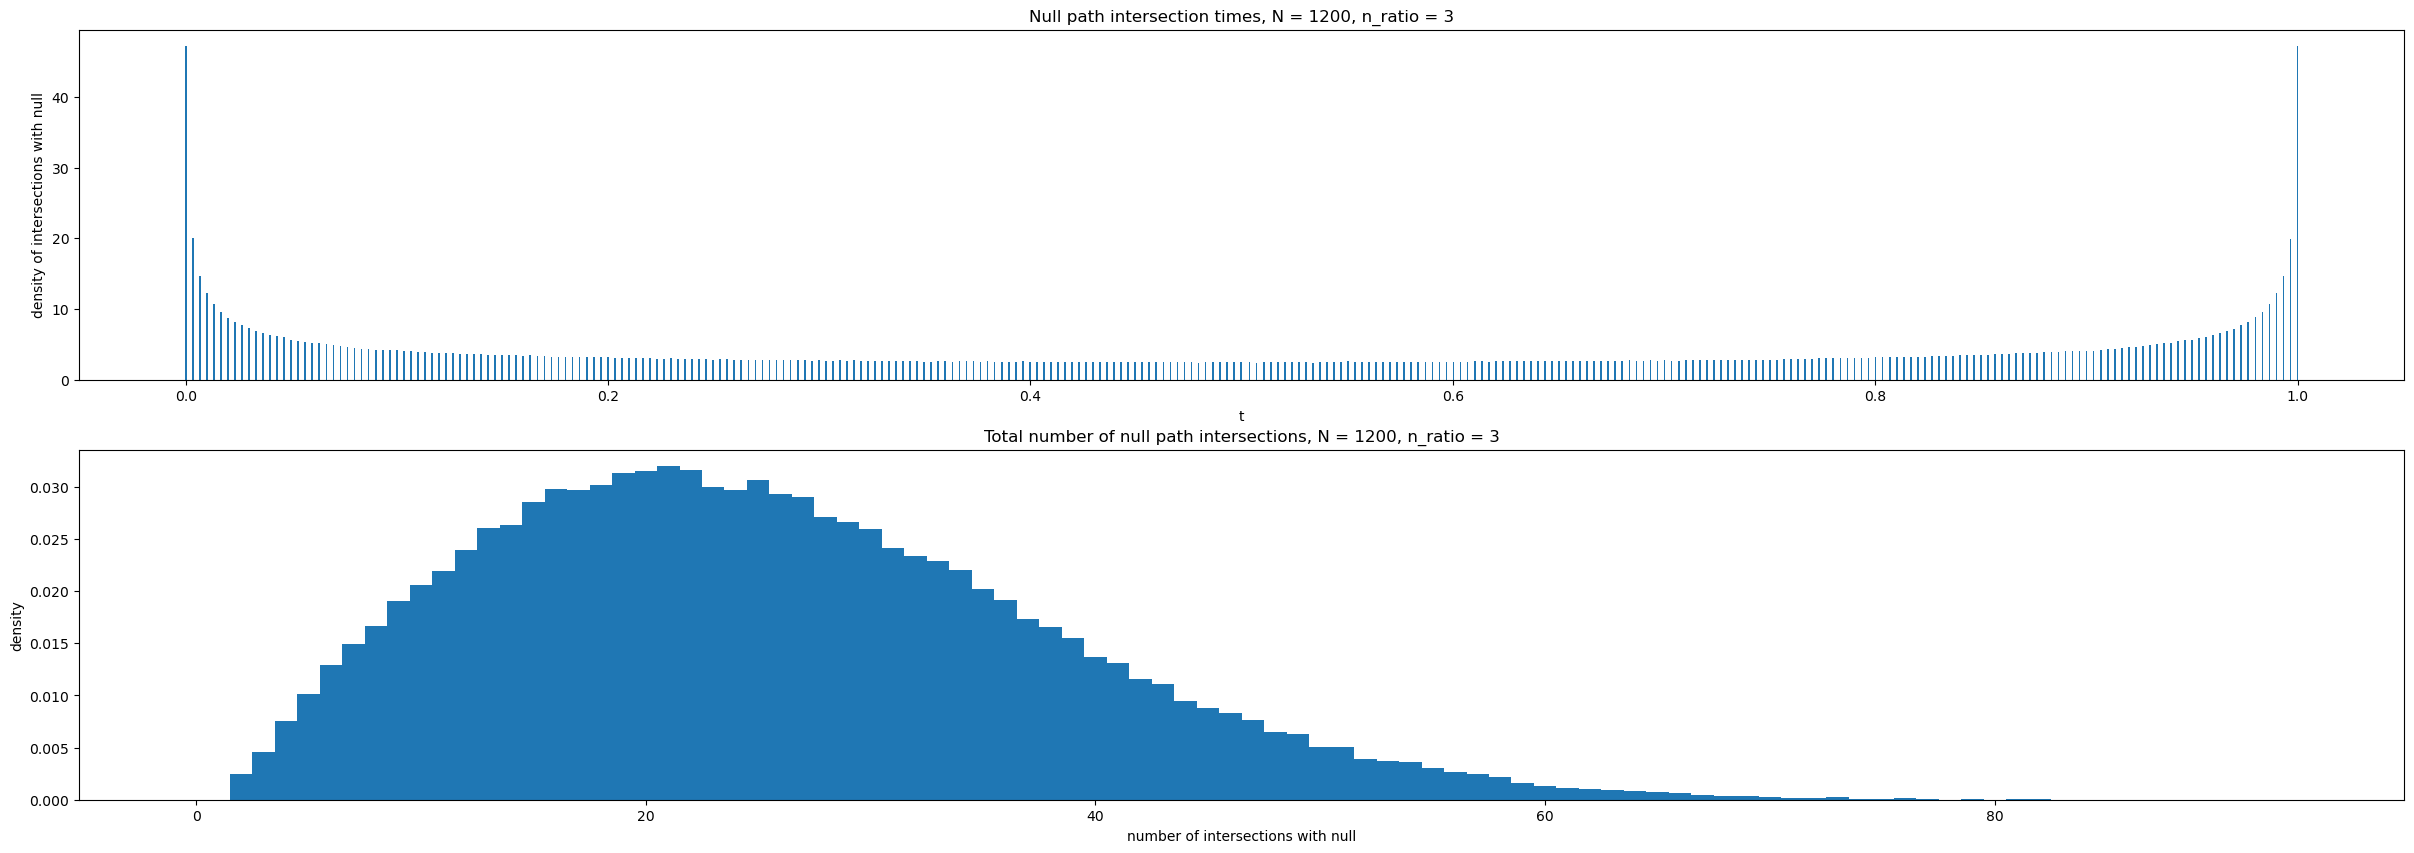

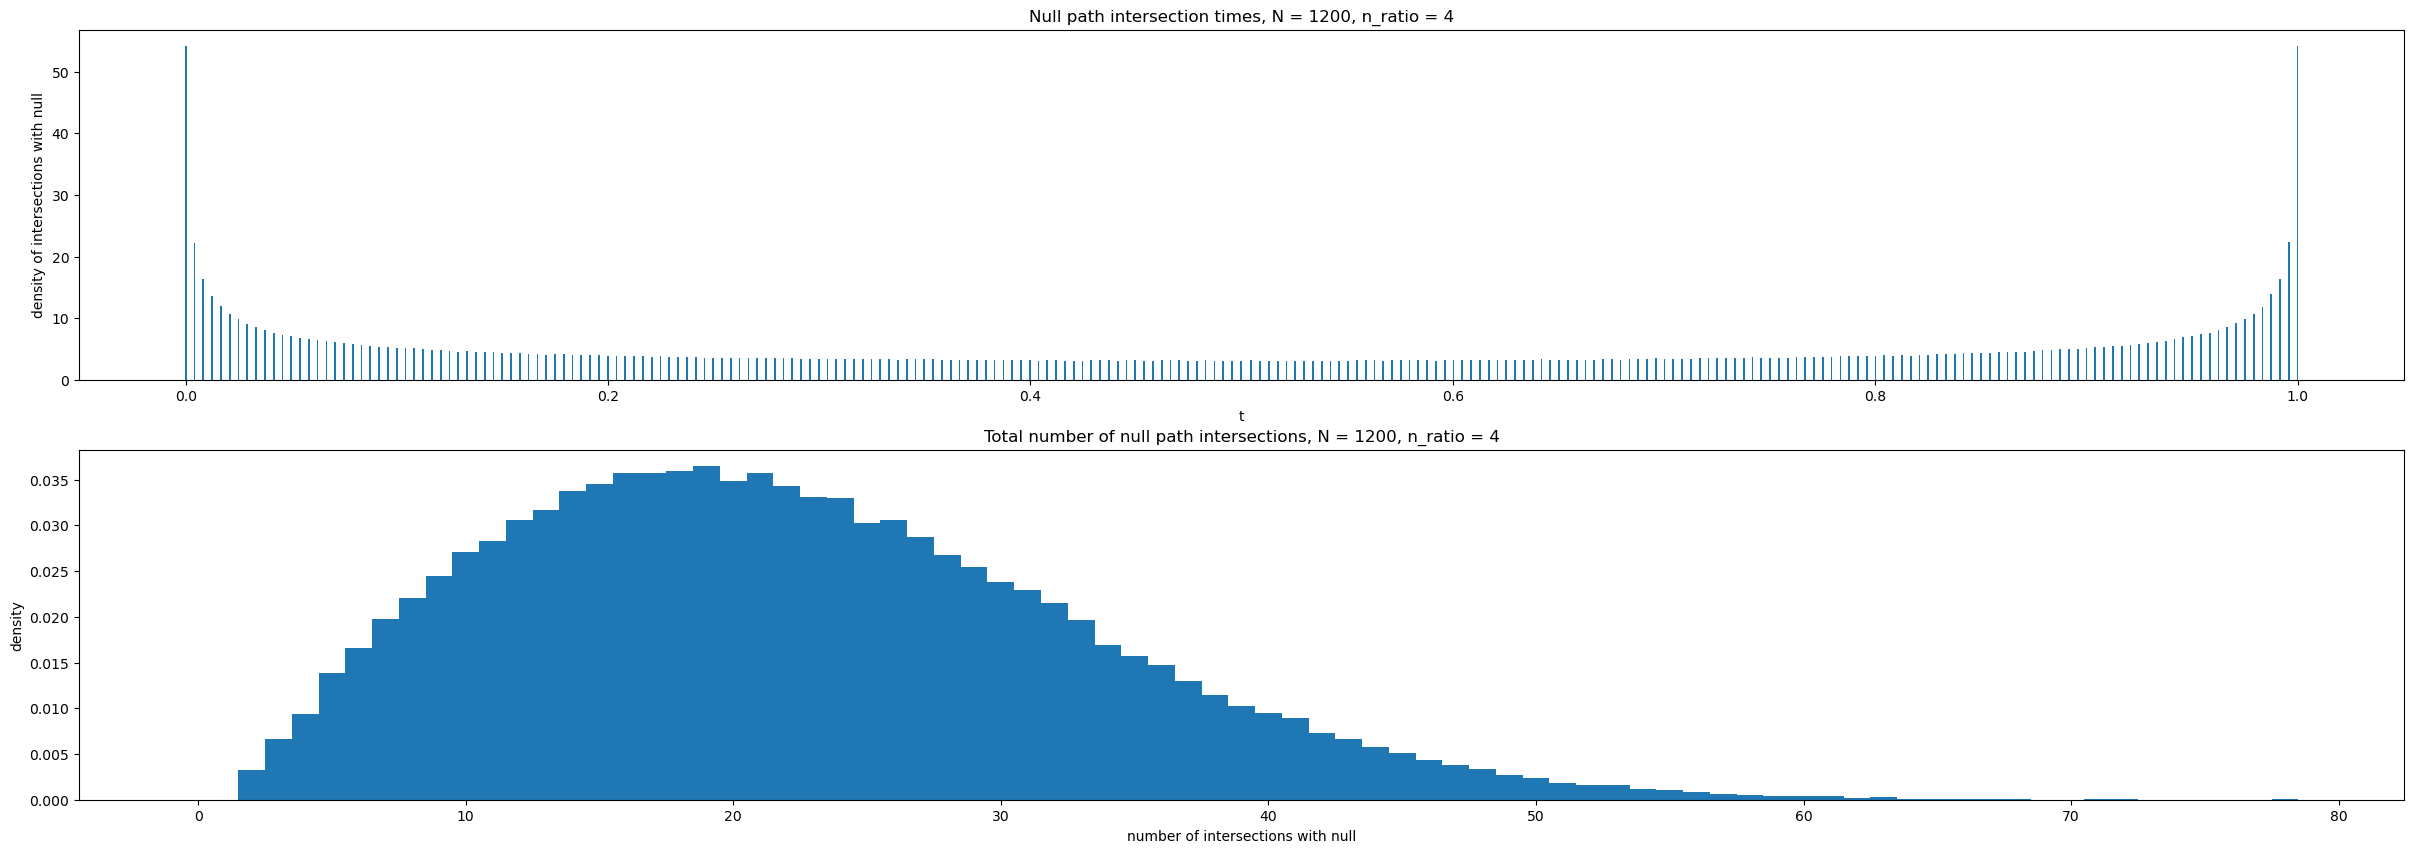

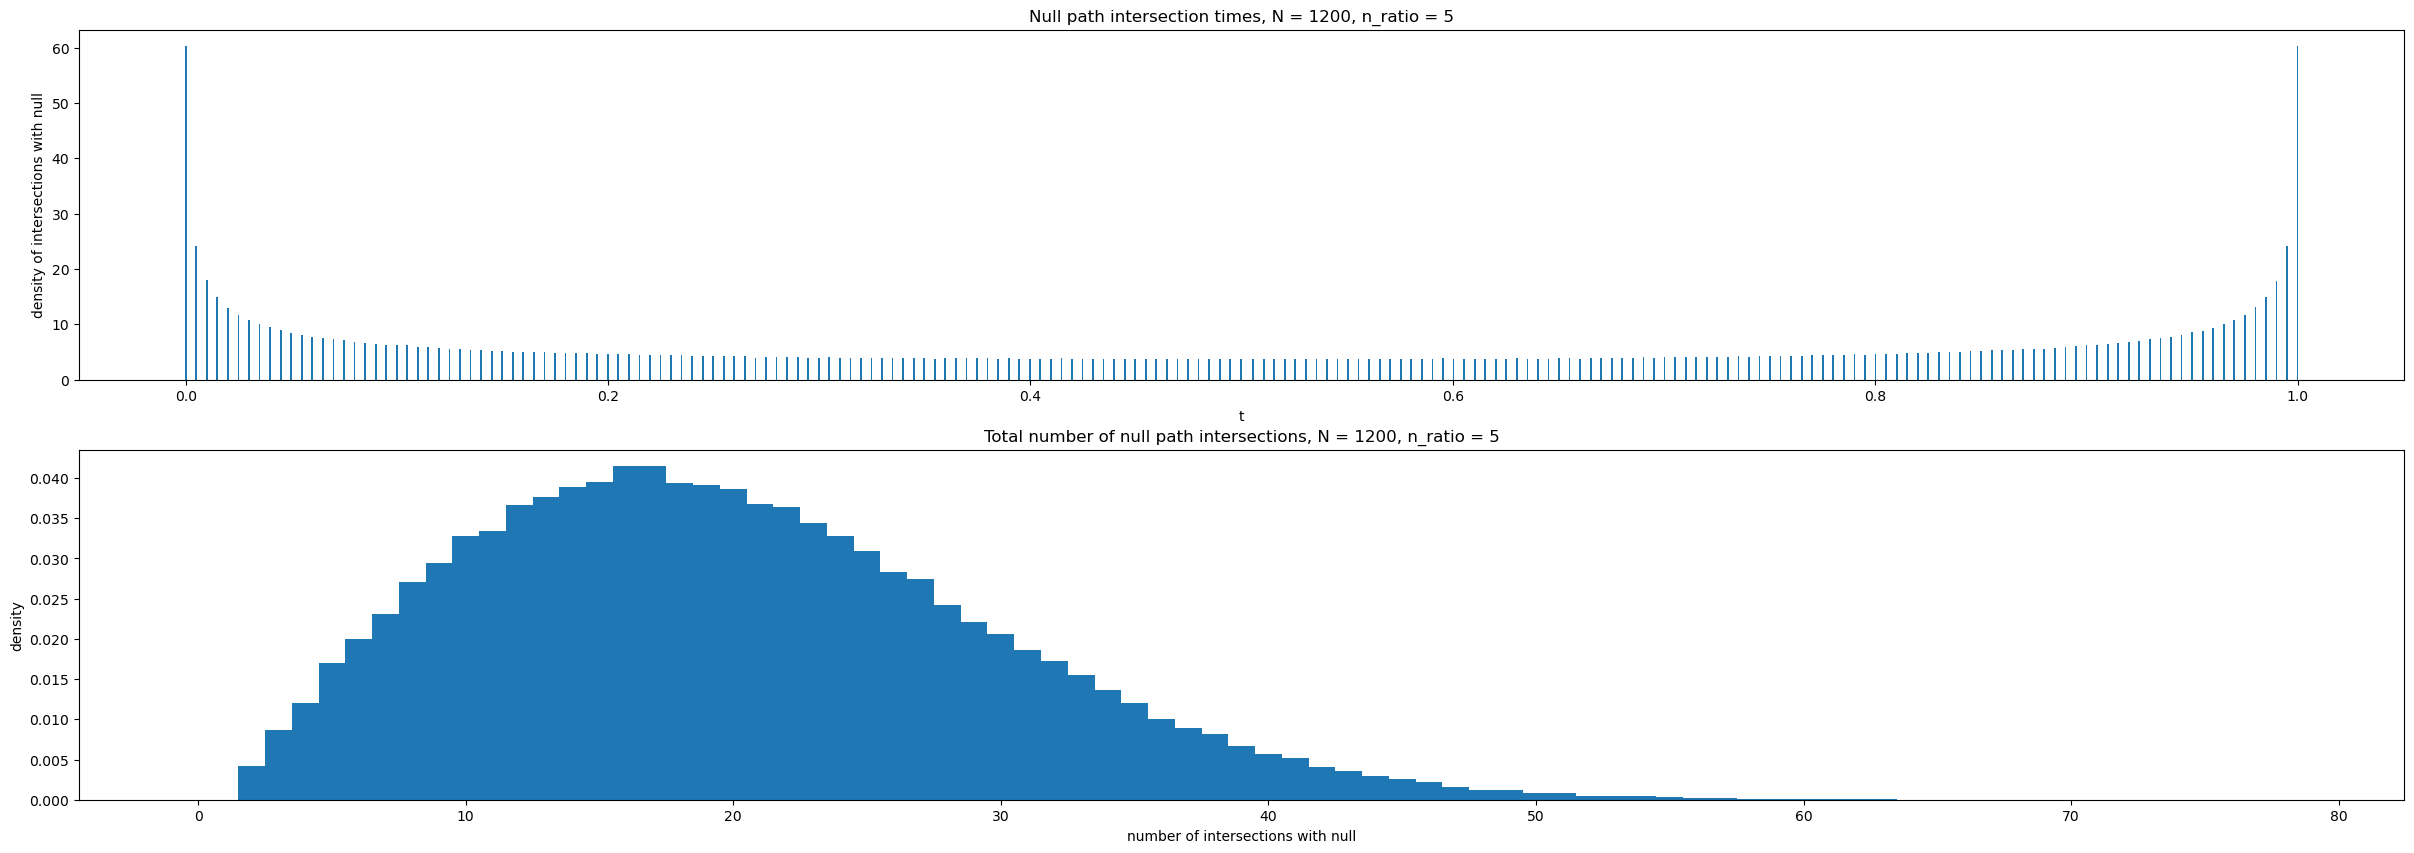

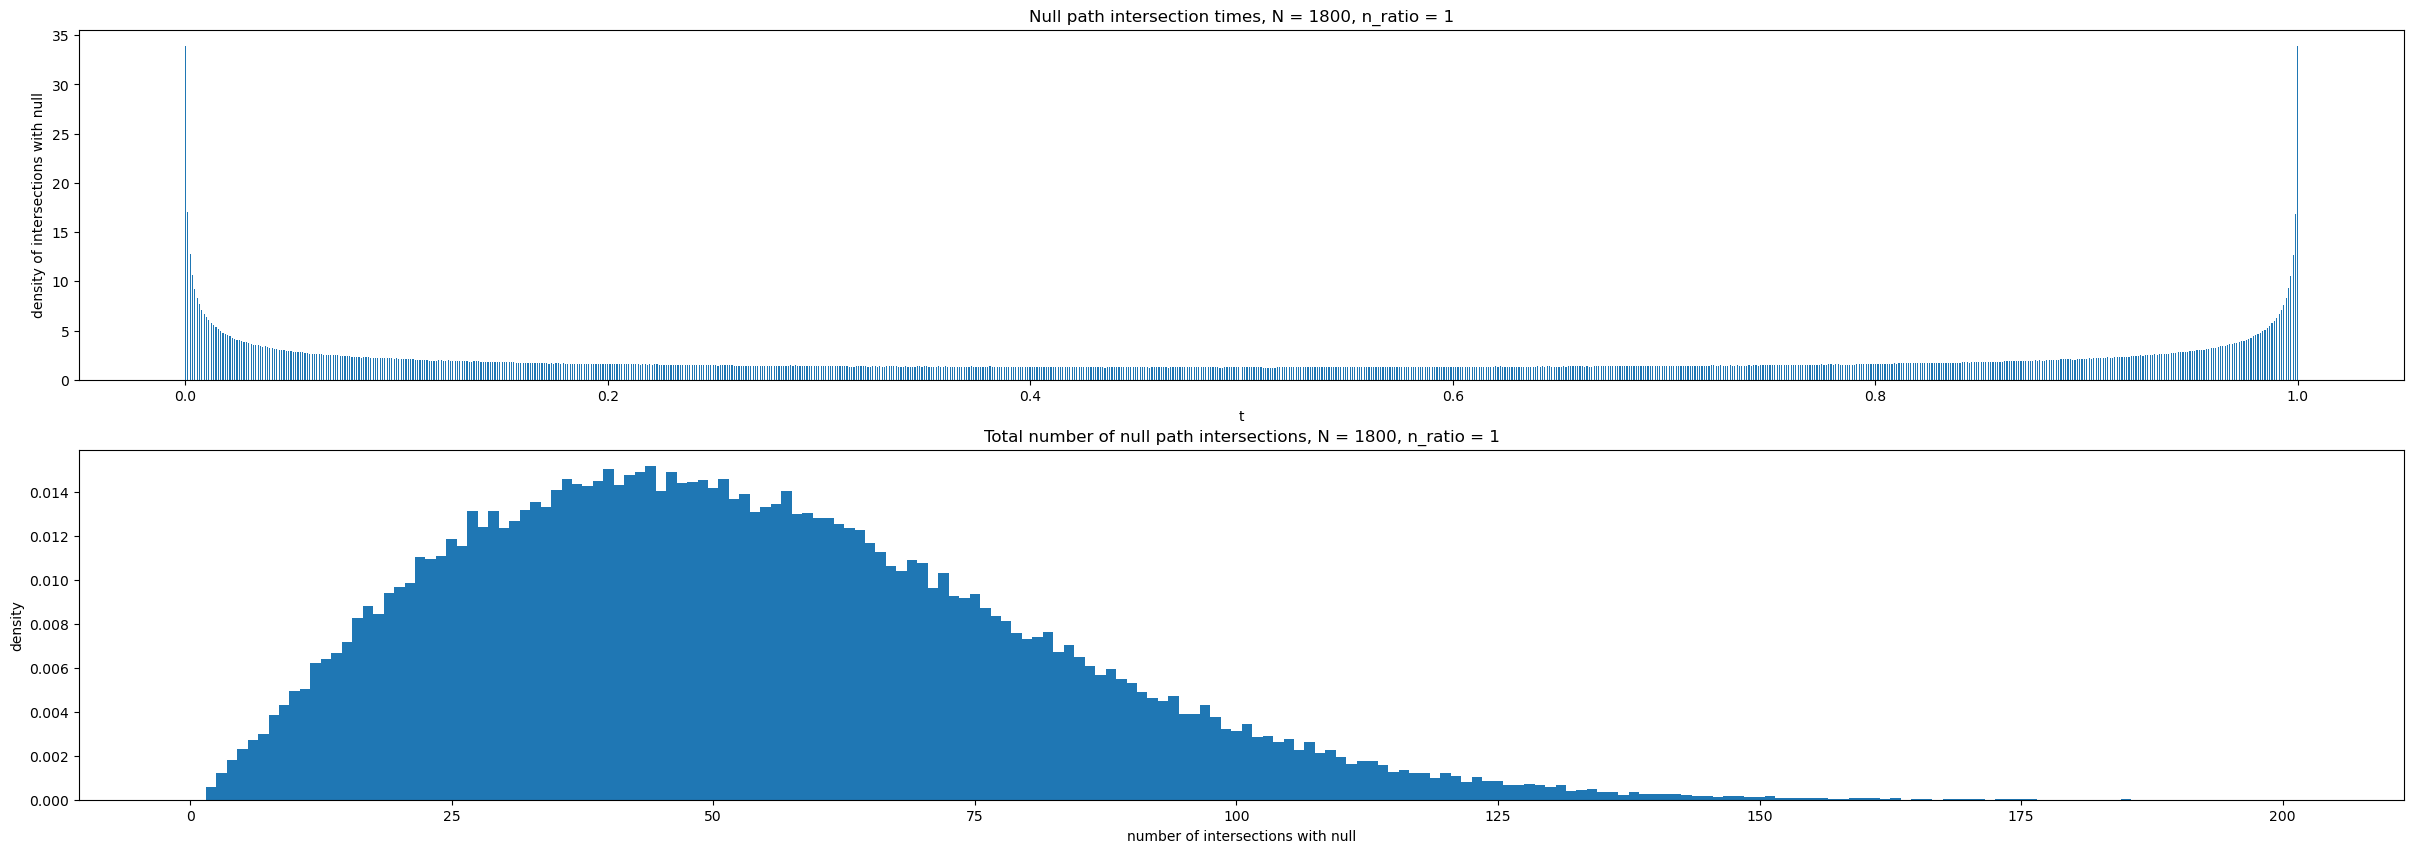

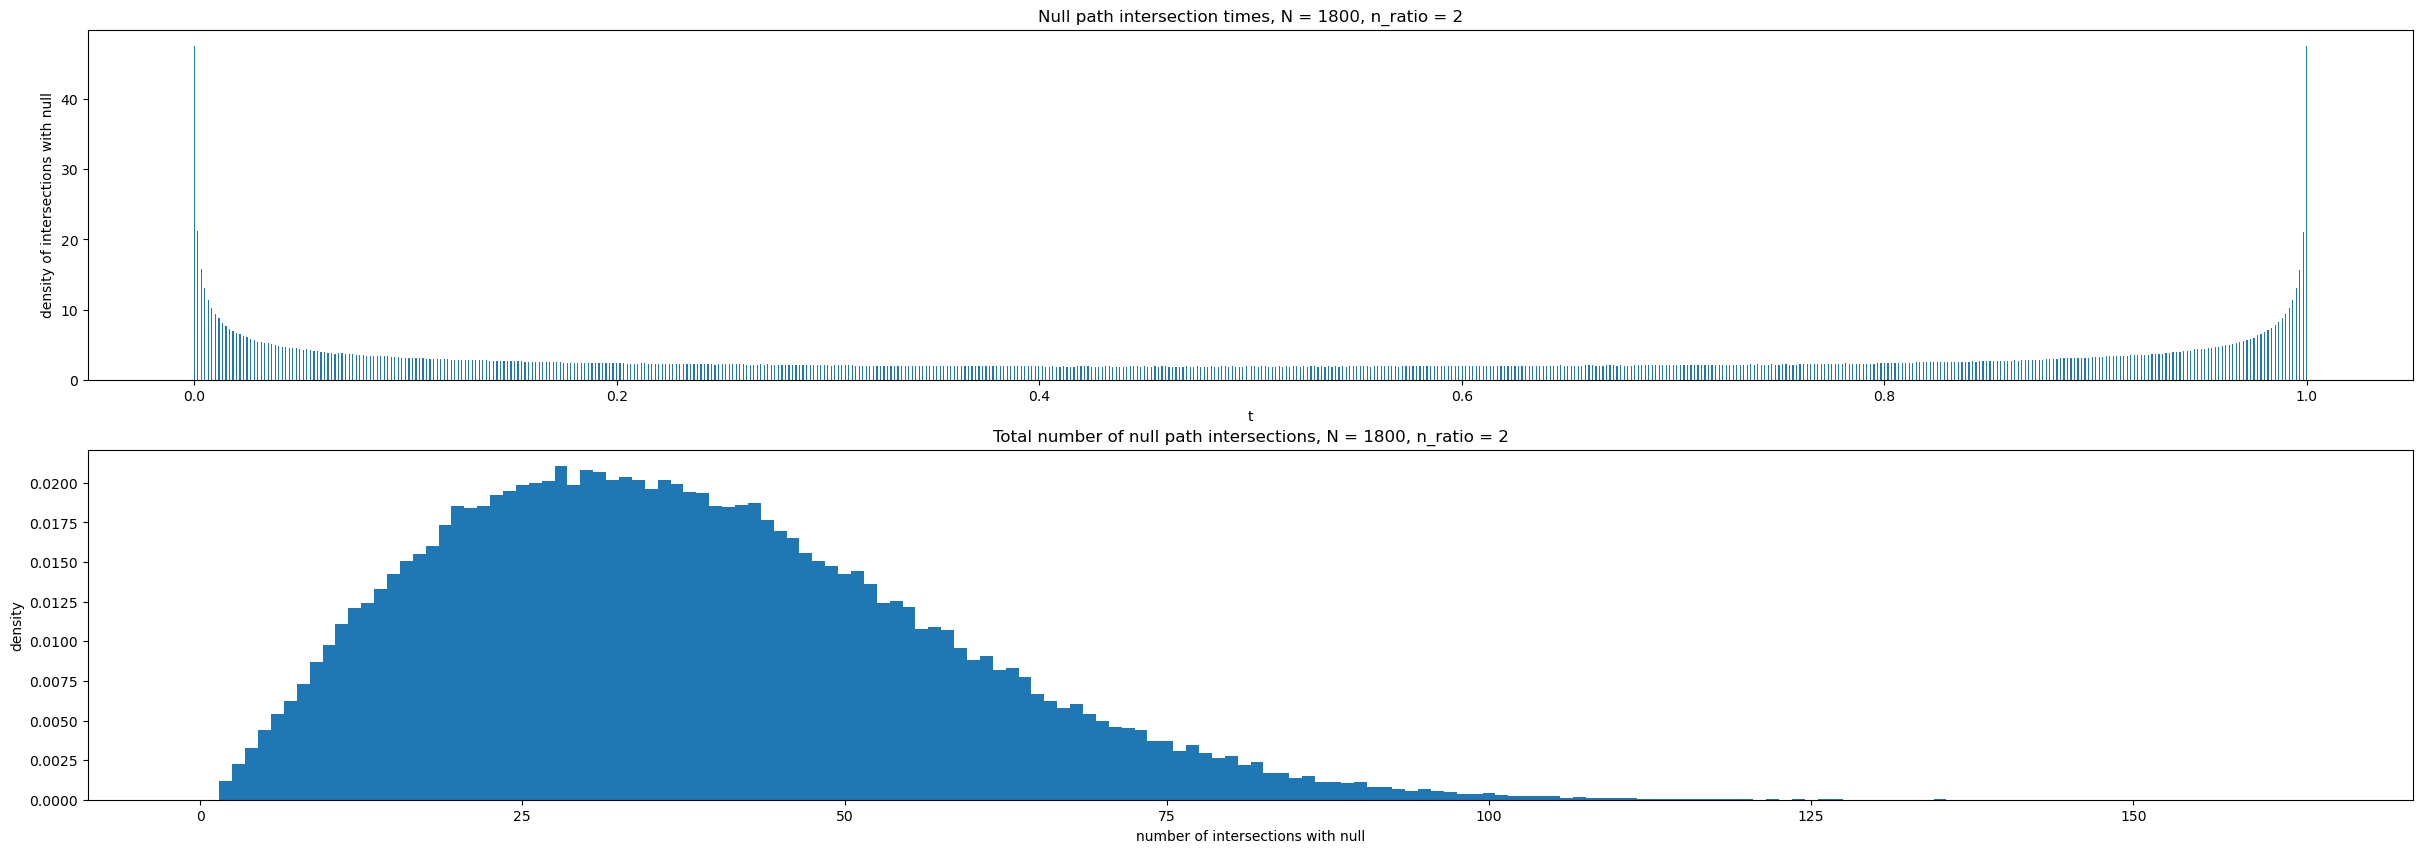

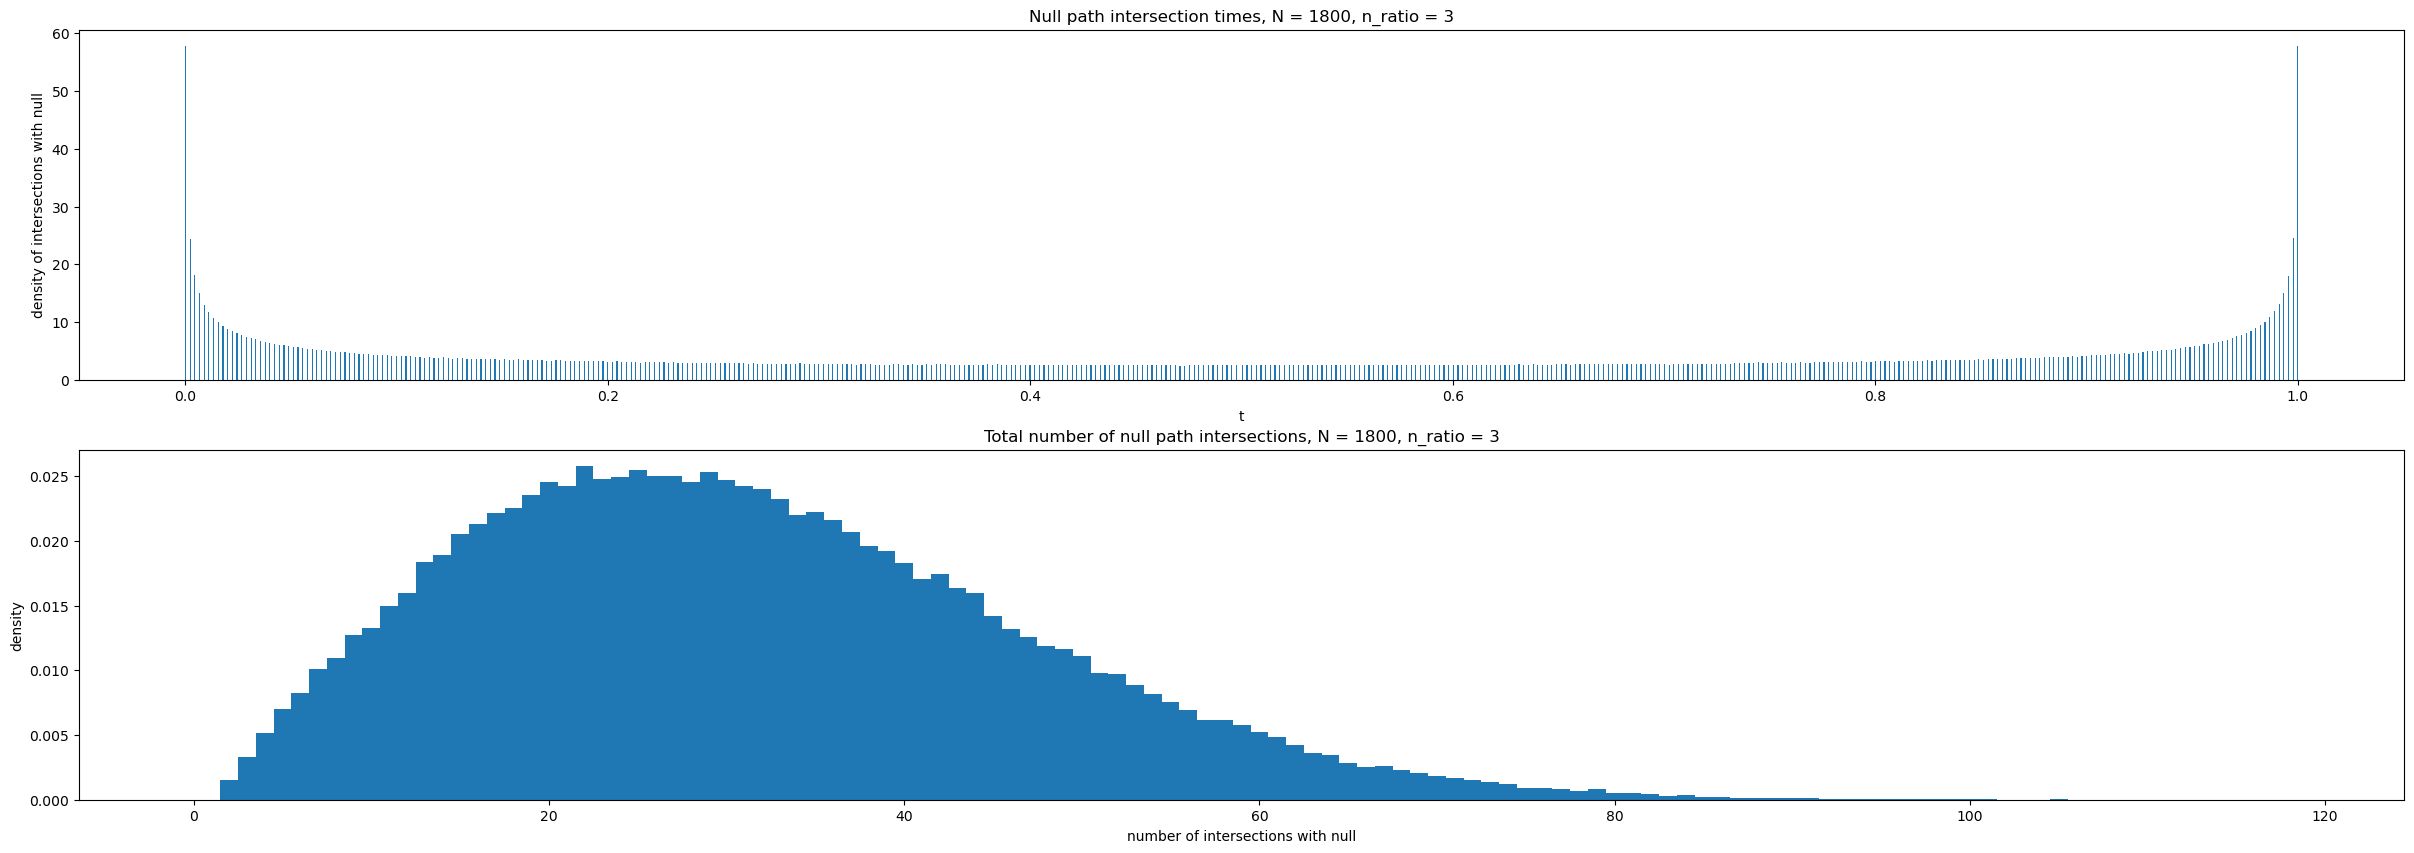

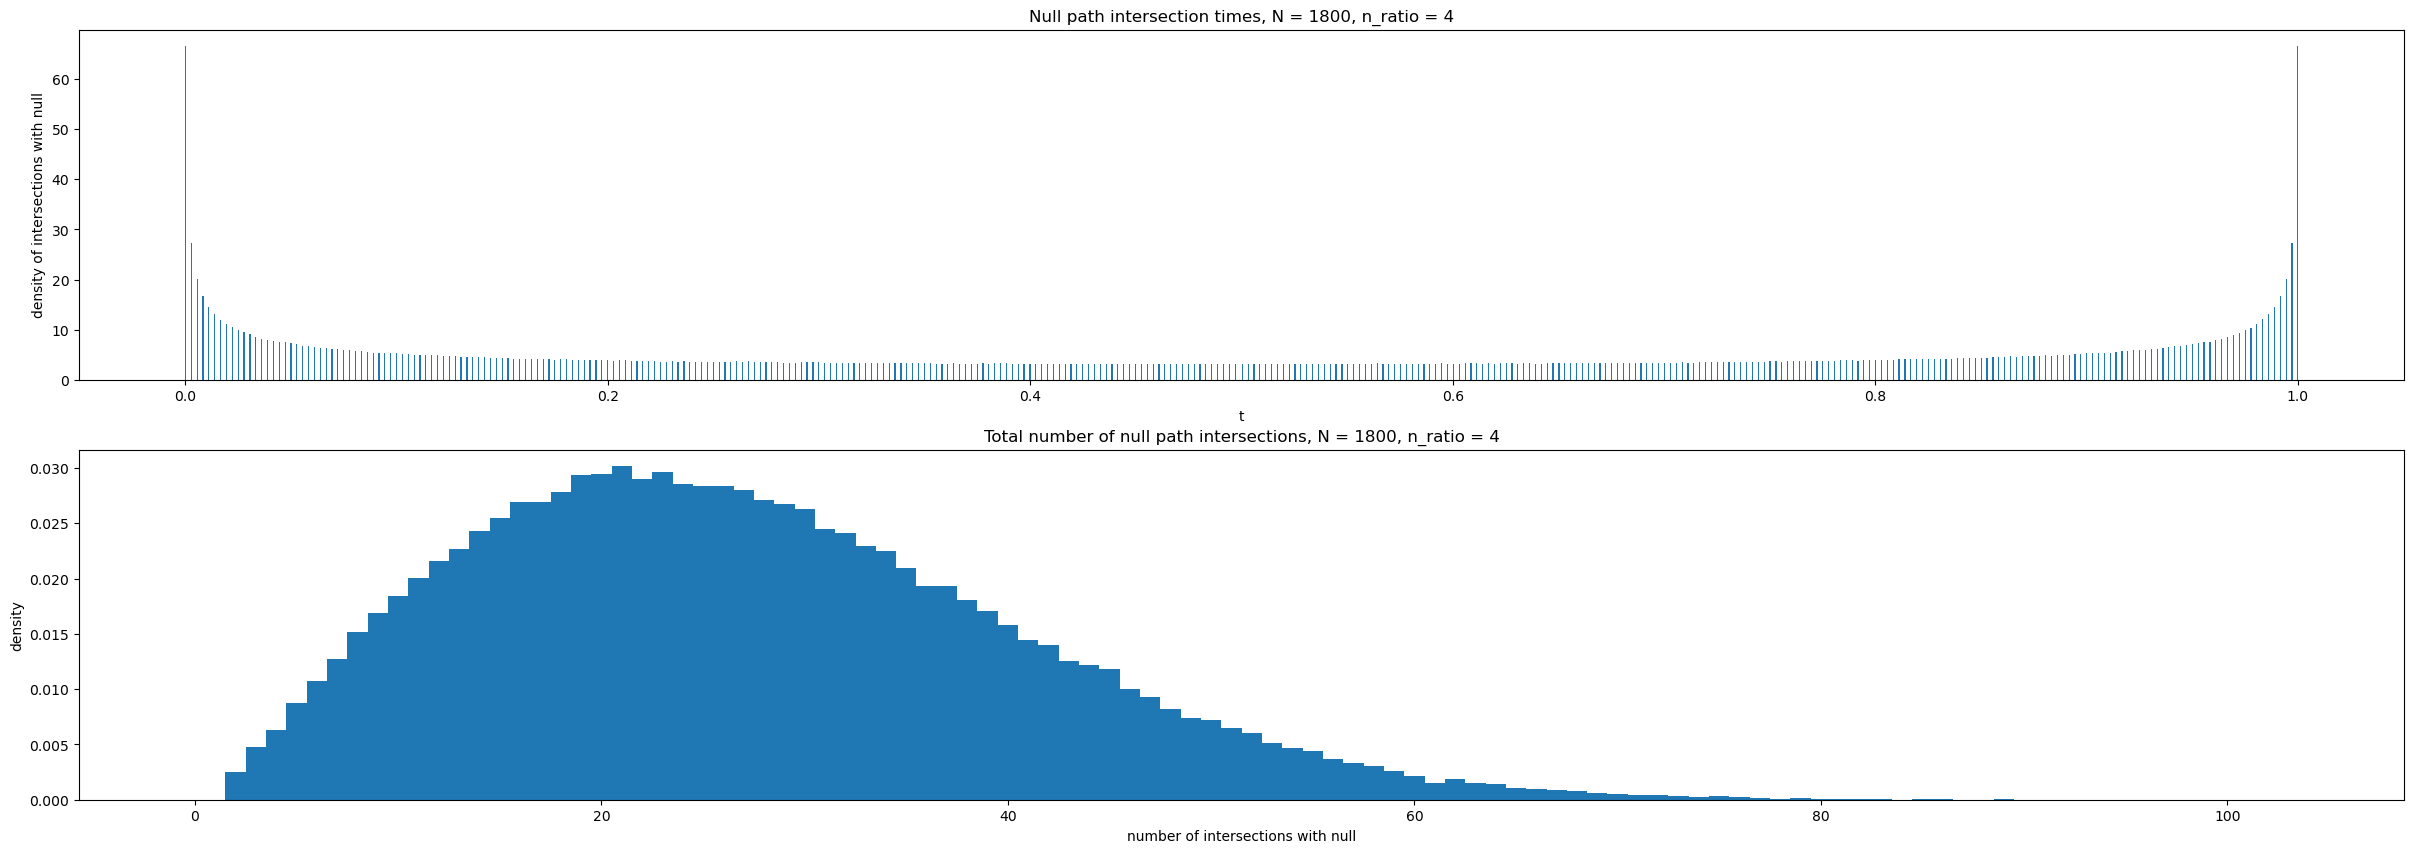

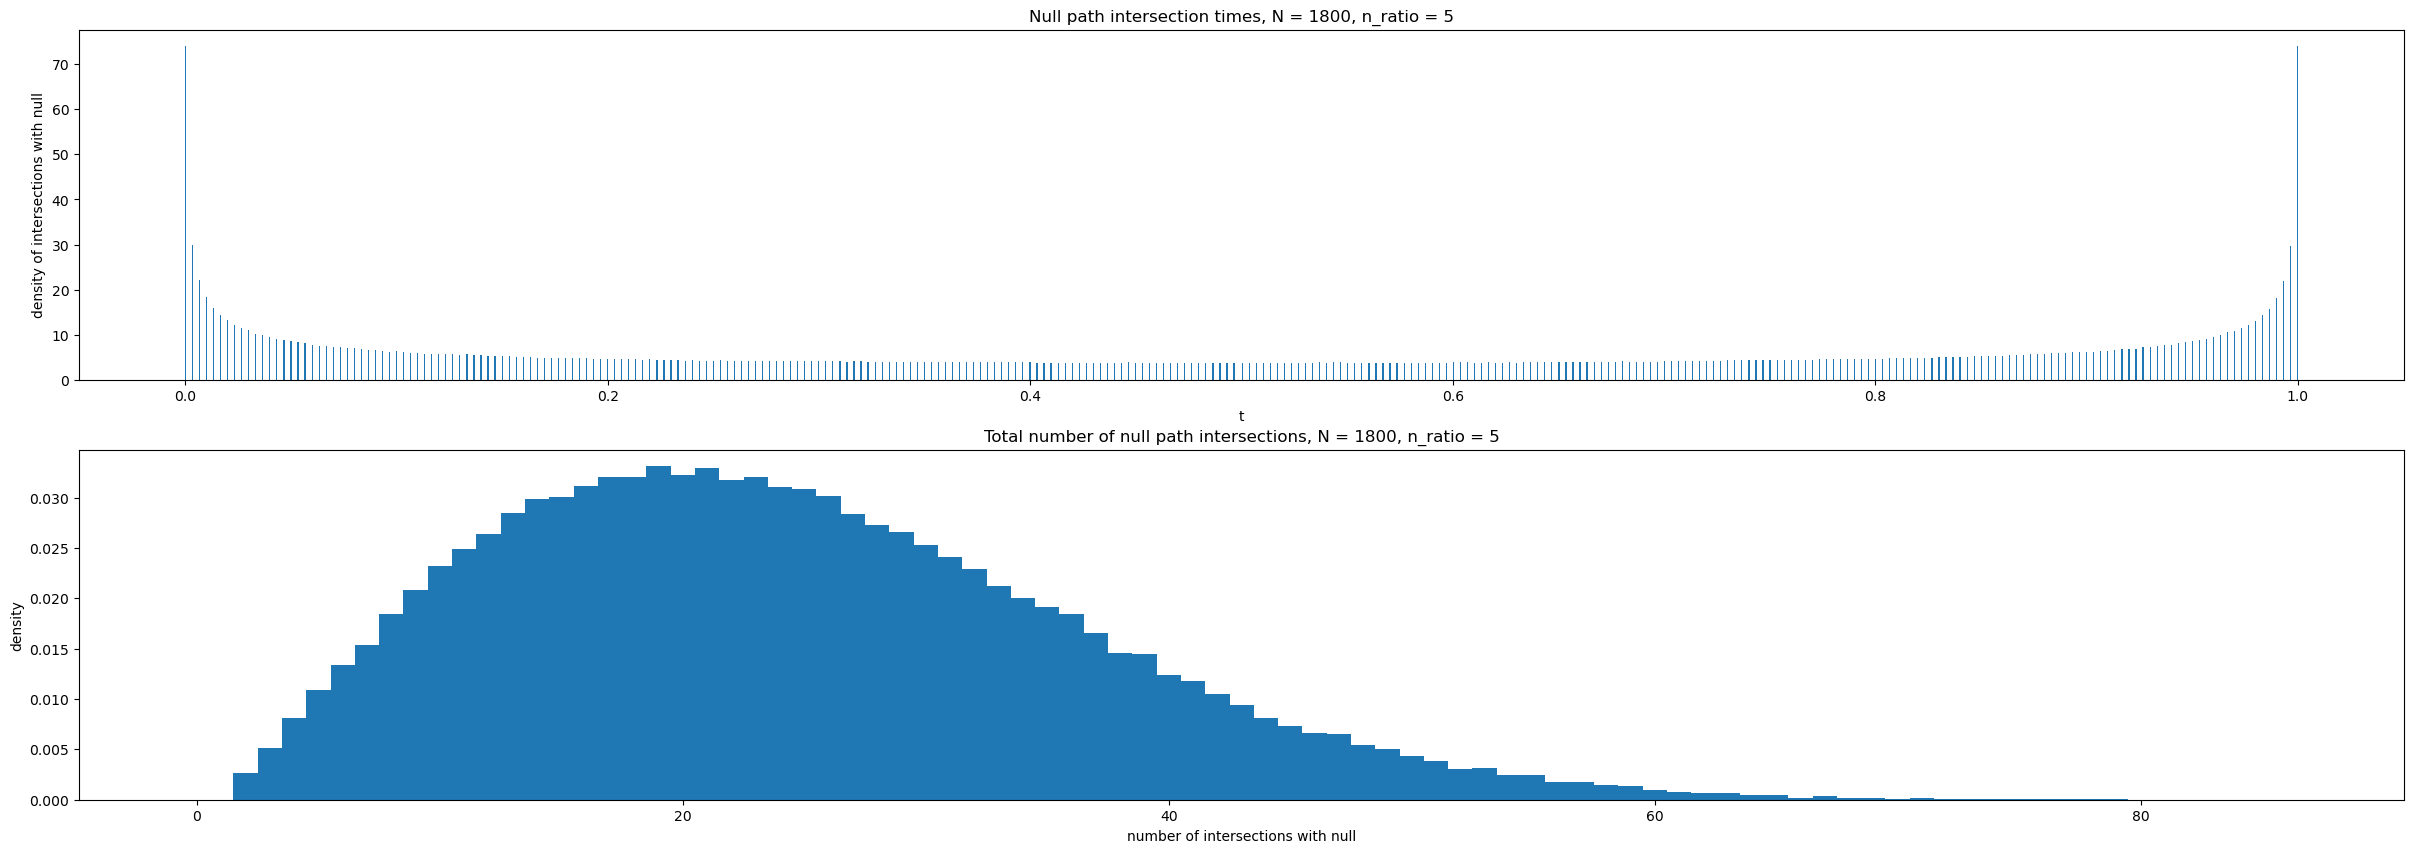

In [ ]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        inters, inter_number = runs[i][j]
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        # axs[1].bar(np.arange(len(inter_number)), inter_number)

        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        plt.show()

In [24]:
mean_recurrences = 1 / inter_number
print(f'mean of mean recurrence times = {np.mean(mean_recurrences)}')

fig, ax = plt.subplots()
ax.hist(mean_recurrences, bins = 100, density = True, range = [0,0.2])
ax.set_title(f"Distribution of mean recurrence times, N = {N}, n_ratio = {n_ratio}")
ax.set_xlabel("time")
ax.set_ylabel("density")
plt.show()

NameError: name 'inter_number' is not defined

In [15]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def parametric(n_ratio, N, ax, c = None):

    x = gillespie(n_ratio, N).get()[0]
    seq = np.array(x[1:] < x[:-1]) * 1
    parametric = [[0],[0]]
    for i in seq:
        parametric[i].append(parametric[i][-1] + 1)
        parametric[i-1].append(parametric[i-1][-1])
    parametric = np.array(parametric) / N
    
    ax.plot(parametric[0], parametric[1], label = f' +/- ratio={n_ratio}', c=c)
    ax.set_title("Path in parametric axes")
    ax.set_xlabel("x+")
    ax.set_ylabel("x-")
    return parametric

def parametric_shifted(n_ratio, N, path, ax):
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])

    # shift by null path
    t = np.linspace(0, 1, N+1)
    shift_plus = Ns[0] / N * t
    shift_minus = Ns[1] / N * t
    x = path[0] - shift_plus
    y = path[1] - shift_minus


    points = np.array([x, y]).transpose().reshape(-1, 1, 2)
    # set up a list of segments
    # segs = np.concatenate([points[:-1],points[1:]],axis=1)
    segs = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('viridis'))

    lc.set_array(t)  # color the segments by our parameter

    # plot the collection

    ax.add_collection(lc)  # add the collection to the plot

    a = list(ax.get_xlim())
    b = list(ax.get_ylim())
    a = [np.min([a[0], x.min()]), np.max([a[1], x.max()])]
    b = [np.min([b[0], y.min()]), np.max([b[1], y.max()])]

    ax.set_xlim(a)
    ax.set_ylim(b)

    ax.set_title("Parametric path shifted by null path")
    ax.set_xlabel("y+")
    ax.set_ylabel("y-")

    return np.array([x, y])

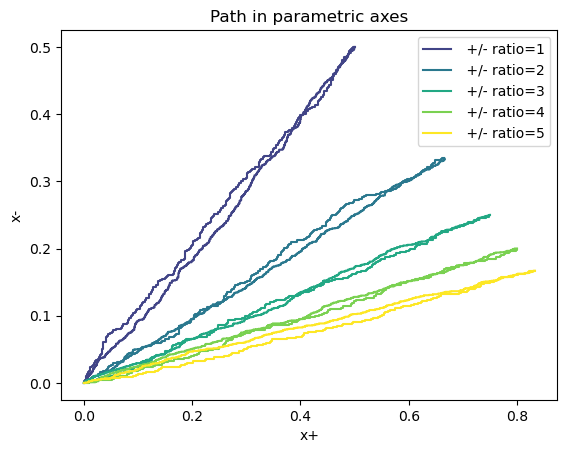

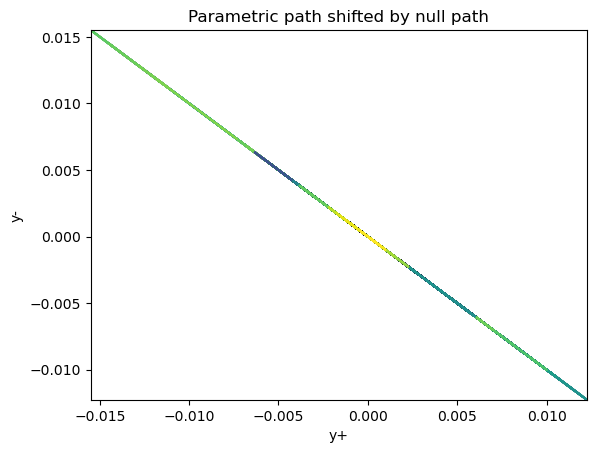

In [16]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)

paths = []
shifted = []
n_ratios = [i for i in range(1,6)]
N1 = [1000 * i for i in range(1,3)]

c = plt.cm.viridis(n_ratios / np.max(n_ratios))

for N in N1:
    paths.append([])
    shifted.append([])
    for j in range(len(n_ratios)):
        paths[-1].append(parametric(n_ratios[j], N, ax1, c=c[j]))
        shifted[-1].append(parametric_shifted(n_ratios[j], N, paths[-1][-1], ax2))
legend_without_duplicate_labels(ax1)
plt.show()

(5, 1001)


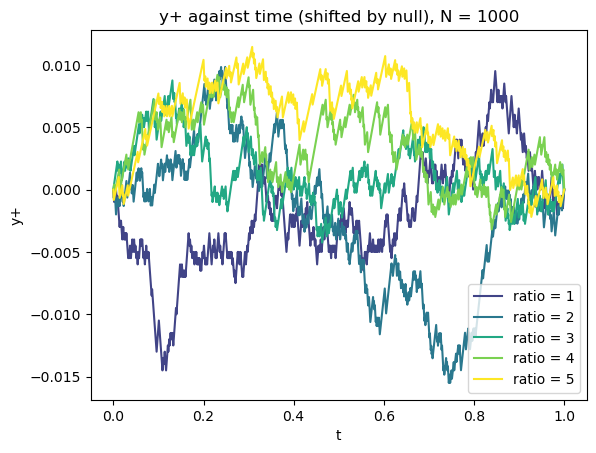

(5, 2001)


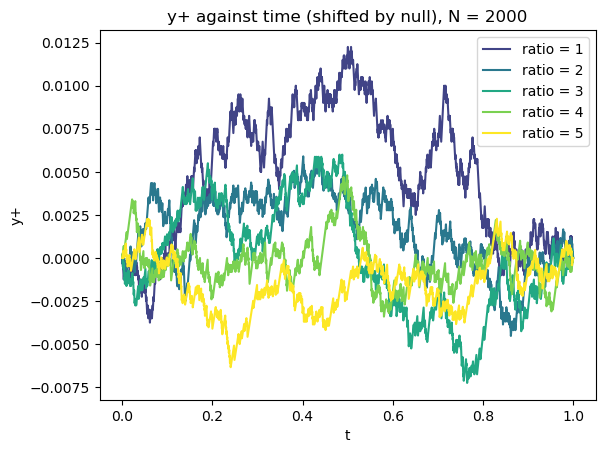

In [17]:
for i in range(len(N1)):
    shifted_plus = np.transpose(shifted[i], [1,0,2])[0]

    print(np.shape(shifted_plus))
    # print(np.shape(np.transpose(shifted[i])))
    t = np.linspace(0, 1, N1[i]+1)
    for j in range(len(n_ratios)):
        plt.plot(t, shifted_plus[j], label = f'ratio = {n_ratios[j]}', c = c[j])

    plt.xlabel("t")
    plt.ylabel("y+")
    plt.title(f"y+ against time (shifted by null), N = {N1[i]}")
    legend_without_duplicate_labels(plt.gca())
    plt.show()